# FINM 33150 Homework 1: Future Spread Dynamics

- Anand Nakhate
- Student ID: 12446907

### Introduction and Motivation

Futures spreads serve as crucial indicators of relative value, market sentiment, and potential arbitrage opportunities. 
This report provides a comprehensive statistical data analysis of two futures spreads (“s1” and “s2”), focusing on their statistical properties, time-varying behaviors, and regime-switching characteristics.

The spreads from two different future pairs are obtained based on the last two digits of Student ID. 
The assignment is meant to be a data science excercise for data retrieval and cleaning, and statistical analysis.

The analysis observes recent periods of high volatility period, particularly in 2022, which saw drastic spread fluctuations driven by geopolitical events, such as the Russia-Ukraine conflict, energy supply disruptions, and interest rate hikes. Understanding these movements is essential for informed decision-making in trading, portfolio risk management, and hedging strategies.

Goals:
- Diagnose the distributional properties of spreads “s1” and “s2”, identifying skewness, kurtosis, and extreme events.
- Investigate temporal dynamics, including rolling averages, volatility clustering, and regime shifts.
- Fit appropriate time-series models (ARIMA, GARCH) and assess model diagnostics.
- Detect structural breaks and infer hidden regimes using Bai-Perron and Hidden Markov Models.

The findings in this report try to bridge statistical analysis with market events. Certain dynamics of the spreads were analyzed and comparisons were made between the two pairs. 


In [1]:
# Standard Library Imports
import os
import datetime
import random
import warnings

# Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import genpareto, skew, kurtosis, t
from scipy.signal import periodogram

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from plotnine import (
    ggplot, aes, geom_line, geom_histogram, geom_boxplot,
    labs, theme_minimal, theme, element_text
)

# Time Series and Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint

# Machine Learning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Financial Time Series Modeling
from arch import arch_model

# Wavelet Transform and Segmentation
import pywt
import ruptures as rpt

# Hidden Markov Models
from hmmlearn.hmm import GaussianHMM

# API for Financial Data
import quandl

# Ignore Warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [3]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Download finished: 326622559 bytes
Removing old symlink
Creating symlink: /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_20250224.zip -> /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_latest.zip


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [4]:
t_ivm.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2',
       'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money',
       'days_expiration', 'days_termination'],
      dtype='object')

In [5]:
t_ivm['date'] = pd.to_datetime(t_ivm['date'])
start_date = pd.to_datetime('2021-12-03')
end_date   = pd.to_datetime('2024-08-31')
t_ivm = t_ivm[(t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)]
t_ivm.reset_index(drop=True, inplace=True)
t_ivm

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,FF,FF,H2026,2024-07-08,96.260,0.407694,NaN,NaN,NaN,...,0.142212,-0.810909,-0.064047,9.675144,1.422305,-31.649977,-0.385662,0.454088,632.08,632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081647,NYX,EMA,EMA,X2026,2024-08-26,195.000,0.148412,0.010962,0.035949,-0.000279,...,0.042915,-0.172628,-0.023582,4.767030,1.211423,-24.077766,-0.331357,0.361790,780.00,801.0
1081648,NYX,EMA,EMA,X2026,2024-08-27,197.500,0.149006,0.011933,0.036486,-0.000418,...,0.046397,-0.203586,-0.002301,5.619866,0.691063,-28.846885,-0.344096,0.349051,779.00,800.0
1081649,NYX,EMA,EMA,X2026,2024-08-28,201.500,0.150180,0.014026,NaN,0.000149,...,0.046619,-0.196339,0.483344,5.079542,-5.786185,-18.506283,-0.230616,0.329000,778.00,799.0
1081650,NYX,EMA,EMA,X2026,2024-08-29,202.750,0.150327,0.015154,NaN,0.000408,...,0.052574,-0.189038,0.291364,5.450350,-3.311838,-25.910404,-0.236800,0.322816,777.00,798.0


In [6]:
def select_second_month(df):
    df_filtered = df[df['days_expiration'] > 30]
    df_sorted = df_filtered.sort_values(['date', 'days_expiration'])
    df_selected = df_sorted.groupby('date').first().reset_index()
    return df_selected

Second-month contracts tend to reflect true price dynamics rather than short-term volatility caused by rollovers and settlement pressures.

### Pair 1: 0. ICE.TFM versus NYM.NG × 13.9239

In [7]:
# W instrument: ICE.TFM
df_W = t_ivm[(t_ivm['exchange_code'] == 'ICE') & (t_ivm['futures_code'] == 'TFM')]
df_W_second = select_second_month(df_W)
df_W_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,ICE,TFM,TFM,1M,89.465172,1.319037,0.376558,0.000734,0.114331,...,0.539308,0.611756,-0.572148,-0.204790,0.769922,-0.256666,-0.638413,0.970686,31.0,31.0
1,2021-12-06,ICE,TFM,TFM,1M,89.906034,1.366206,0.366281,NaN,0.105988,...,0.535400,0.503298,-0.665416,0.003996,0.899471,-0.478176,-0.653545,0.989814,31.0,31.0
2,2021-12-07,ICE,TFM,TFM,1M,95.856517,1.349121,0.349928,NaN,0.102696,...,0.488888,0.437723,-0.331826,0.205791,0.466401,-0.436356,-0.640064,0.926889,31.0,31.0
3,2021-12-08,ICE,TFM,TFM,1M,101.475000,1.422079,0.376503,NaN,0.116080,...,0.475110,0.460816,-0.141279,-0.063249,0.034089,-0.055042,-0.683960,0.915476,31.0,31.0
4,2021-12-09,ICE,TFM,TFM,1M,100.438448,1.400012,0.403893,NaN,0.109052,...,0.560443,0.263245,-0.166715,0.374300,-0.069076,-0.230129,-0.637622,0.938439,31.0,31.0


In [8]:
# X instrument: NYM.NG * 13.9239
df_X = t_ivm[(t_ivm['exchange_code'] == 'NYM') & (t_ivm['futures_code'] == 'NG')]
df_X_second = select_second_month(df_X)
df_X_second = df_X_second.copy()  
df_X_second['futures_adj'] = df_X_second['futures'] * 13.9239
df_X_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,NYM,NG,NG,1M,4.121828,0.724024,0.214463,0.399080,0.038595,...,0.427835,-2.059052,2.161980,1.607154,-2.317277,-0.335525,0.792773,31.0,31.0,57.391915
1,2021-12-06,NYM,NG,NG,1M,3.648172,0.681706,0.155498,0.291336,0.038884,...,1.122779,-2.427590,-0.697706,7.756482,-6.066430,-0.358451,0.722753,31.0,31.0,50.796788
2,2021-12-07,NYM,NG,NG,1M,3.697448,0.698561,0.109787,0.241150,0.021800,...,0.439699,0.010424,1.568657,-4.923368,3.993275,-0.359257,0.729975,31.0,31.0,51.482900
3,2021-12-08,NYM,NG,NG,1M,3.800862,0.741330,0.110508,0.244537,0.021498,...,0.352477,0.308783,0.933130,-4.626956,4.121580,-0.389523,0.730843,31.0,31.0,52.922823
4,2021-12-09,NYM,NG,NG,1M,3.802621,0.685000,0.125825,0.279933,0.020226,...,0.175057,0.784971,3.686666,-15.410017,12.795293,-0.362717,0.664367,31.0,31.0,52.947310


In [9]:
df_pair1 = pd.merge(
    df_W_second[['date', 'futures']],
    df_X_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)

df_pair1.rename(columns={'futures': 'W', 'futures_adj': 'X'}, inplace=True)
df_pair1['s1'] = df_pair1['X'] - df_pair1['W']
df_pair1.set_index('date', inplace=True)
df_pair1.sort_index(inplace=True)
df_pair1.head()

,W,X,s1
date,,,
2021-12-03,89.465172,57.391915,-32.073257
2021-12-06,89.906034,50.796788,-39.109247
2021-12-07,95.856517,51.482900,-44.373617
2021-12-08,101.475000,52.922823,-48.552177
2021-12-09,100.438448,52.947310,-47.491138


In [10]:
# Analyzes spread data for info, missing values, and duplicate dates.
def analyze_spread_data(spread_df, spread_name="Spread Data"):
    print(f"\n--- {spread_name} Information ---")
    print(spread_df.info())
    print("\n--- Missing Values ---")
    print(spread_df.isnull().sum())
    print("\n--- Describe Values ---")
    print(spread_df.describe())
    print(f"\n--- Duplicated Dates ---\n{spread_df.index.duplicated().sum()} duplicate entries found in index")

analyze_spread_data(df_pair1, "s1")


--- s1 Information ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 709 entries, 2021-12-03 to 2024-08-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   W       709 non-null    float64
 1   X       709 non-null    float64
 2   s1      709 non-null    float64
dtypes: float64(3)
memory usage: 22.2 KB
None

--- Missing Values ---
W     0
X     0
s1    0
dtype: int64

--- Describe Values ---
                W           X          s1
count  709.000000  709.000000  709.000000
mean    76.145652   56.535866  -19.609786
std     58.115357   30.321537   35.784674
min     23.066000   22.918739 -217.172213
25%     34.165000   33.862925  -27.610917
50%     47.018000   41.590689   -5.405373
75%    103.809000   79.194502    1.209930
max    346.172345  134.415761   47.468944

--- Duplicated Dates ---
0 duplicate entries found in index


- The descriptive statistics show a negative mean of  −19.61 with significant volatility of 35.78 suggesting substantial volatility in the relative price dynamics between WTI crude and natural gas futures.
- The extreme minimum of −217.17 suggests high left-tail risks that are likely related to the 2022 energy crisis, where geopolitical shocks drastically widened the spread.


In [11]:
# Detects and displays outliers in the spread data based on Z-scores.
def detect_outliers_zscore(spread_df, spread_column='s1', threshold=3):
    spread_df[f'{spread_column}_zscore'] = (spread_df[spread_column] - spread_df[spread_column].mean()) / spread_df[spread_column].std(ddof=0)
    outliers_df = spread_df[np.abs(spread_df[f'{spread_column}_zscore']) > threshold]
    print(f"Number of outliers in {spread_column} (Z-score>{threshold}): {len(outliers_df)}")
    try:
        return outliers_df[['W', 'X', spread_column, f'{spread_column}_zscore']]
    except:
        return outliers_df[['Y', 'Z', spread_column, f'{spread_column}_zscore']]
outliers_s1 = detect_outliers_zscore(df_pair1, spread_column='s1', threshold=3)
outliers_s1

Number of outliers in s1 (Z-score>3): 13


,W,X,s1,s1_zscore
date,,,,
2021-12-21,179.978724,52.822475,-127.156249,-3.007499
2022-03-07,224.467759,67.402239,-157.065520,-3.843902
2022-03-08,212.038966,63.206344,-148.832622,-3.613672
2022-08-22,279.362333,134.415761,-144.946572,-3.505000
2022-08-23,272.177800,127.561489,-144.616311,-3.495764
2022-08-24,295.401667,129.547966,-165.853701,-4.089660
2022-08-25,325.372067,130.148086,-195.223981,-4.910990
2022-08-26,346.172345,129.000132,-217.172213,-5.524765
2022-08-29,292.432000,130.024259,-162.407741,-3.993295


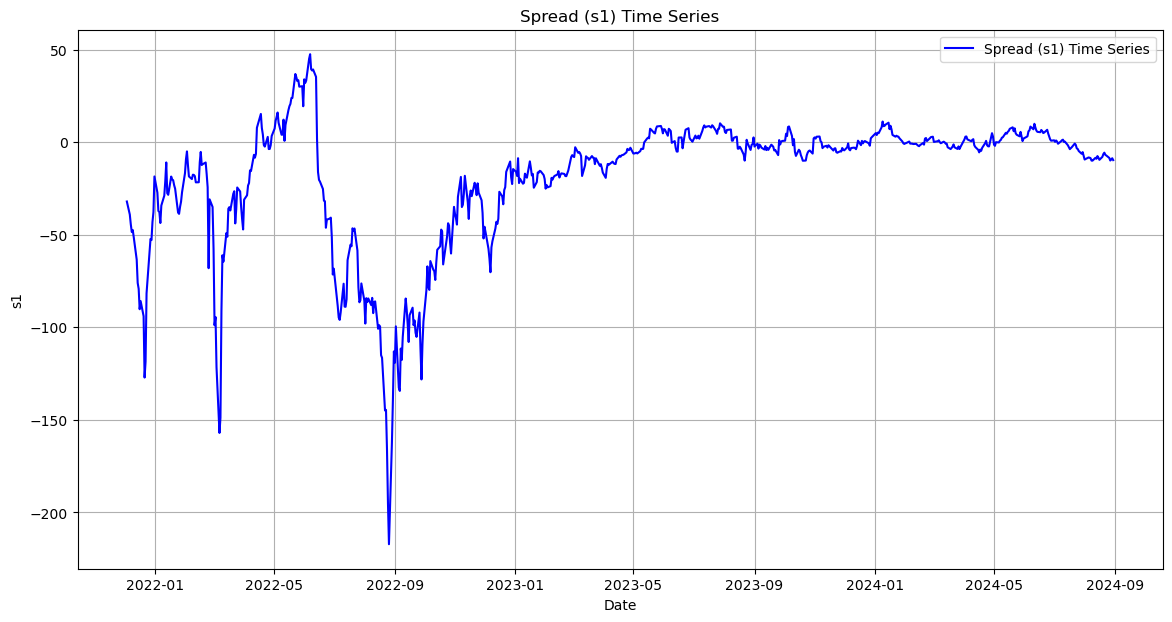

In [12]:
# Plots the time series of the given spread data.
def plot_spread_time_series(spread_df, spread_column='s1', spread_name='Spread Time Series', color='blue'):
    plt.figure(figsize=(14, 7))
    plt.plot(spread_df.index, spread_df[spread_column], label=f'{spread_name}', color=color)
    plt.title(f"{spread_name}")
    plt.xlabel("Date")
    plt.ylabel(f"{spread_column}")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_spread_time_series(df_pair1, spread_column='s1', spread_name='Spread (s1) Time Series', color='blue')

- The time-series plot shows the extreme volatility of the spread s1, with a sharp decline during mid-2022, reflecting the energy market volatility triggered by geopolitical events like the Russia-Ukraine conflict.
- The drop below -200 shows a significant systemic shock, suggesting the market’s sensitivity to supply chain disruptions and price dislocations.
- The gradual recovery and stabilization around zero in 2023 indicate a return to relative market equilibrium as energy prices normalized.
- Minor fluctuations post-2023 suggest less volatile conditions but persistent market pressures, influenced by ongoing macroeconomic uncertainties and policy shifts.
- This visualization highlights the need for adaptive models to detect regime shifts.

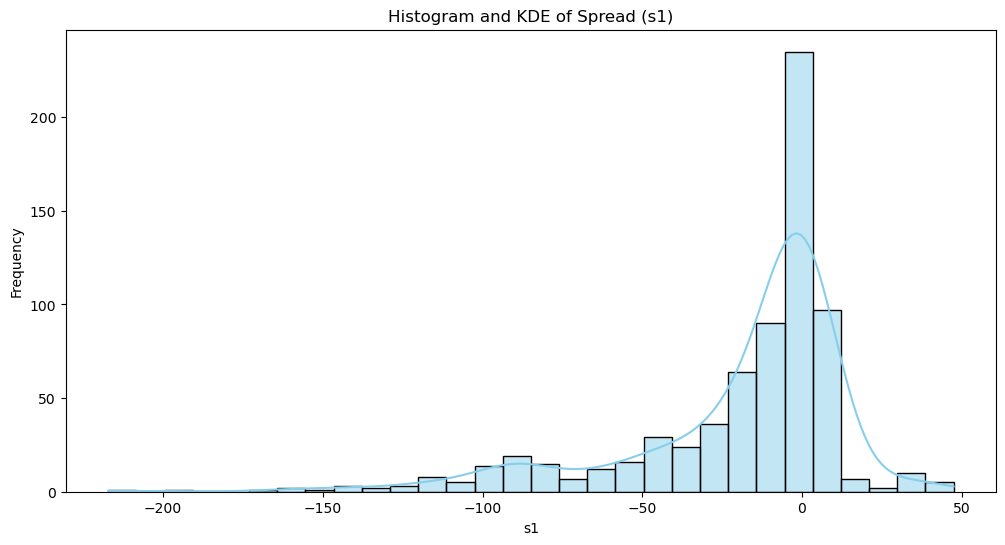

In [13]:
# Generates a histogram with KDE for the given spread data.
def plot_spread_histogram_kde(spread_df, spread_column='s1', spread_name='Spread (s1)', bins=30, color='skyblue'):
    plt.figure(figsize=(12, 6))
    sns.histplot(spread_df[spread_column], kde=True, bins=bins, color=color)
    plt.title(f"Histogram and KDE of {spread_name}")
    plt.xlabel(f"{spread_column}")
    plt.ylabel("Frequency")
    plt.show()
plot_spread_histogram_kde(df_pair1, spread_column='s1', spread_name='Spread (s1)', bins=30, color='skyblue')

- The histogram and KDE plot for spread s1 show a strong left skew, with the majority of the observations concentrated near zero but a significant tail extending into extreme negative values.
- The peak near zero suggests that the spread moves around the median, suggesting balanced price movements during stable market periods.
- The left tail, with values plunging below -200, corresponds to rare but severe market events, likely driven by systemic energy market disruptions during 2022.
- This distribution highlights the non-normal nature of the spread, suggesting the need for models that account for heavy tails and outlier behavior to avoid underestimating extreme downside risks.
- The shape of the KDE curve aligns with real-world conditions where geopolitical shocks, such as supply constraints, caused sudden negative spikes in the relative pricing between WTI crude and natural gas futures.

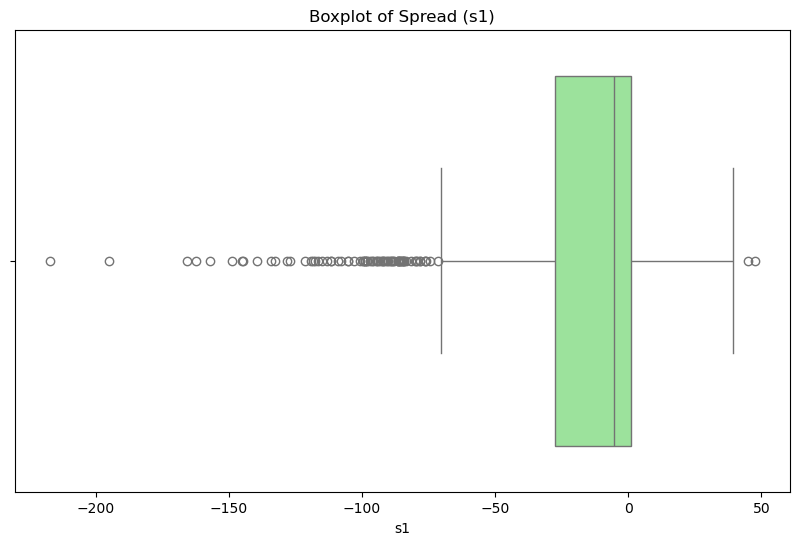

In [14]:
# Plots a boxplot of the given spread data.
def plot_spread_boxplot(spread_df, spread_column='s1', spread_name='Spread Boxplot', color='lightgreen'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=spread_df[spread_column], color=color)
    plt.title(f"Boxplot of {spread_name}")
    plt.xlabel(f"{spread_column}")
    plt.show()
plot_spread_boxplot(df_pair1, spread_column='s1', spread_name='Spread (s1)', color='lightgreen')

- The boxplot visualizes the spread's distribution, highlighting its central tendency around zero, reflecting market balance during normal periods.
- The extended lower whisker and dense cluster of negative outliers indicate extreme downside movements, emphasizing vulnerability to systemic shocks.
- The absence of large positive outliers reveals asymmetric risk, where negative events dominate the spread's volatility profile.
- These extreme negative values correspond to real-world crises like the 2022 energy supply disruptions, reinforcing the impact of external shocks on relative commodity pricing.

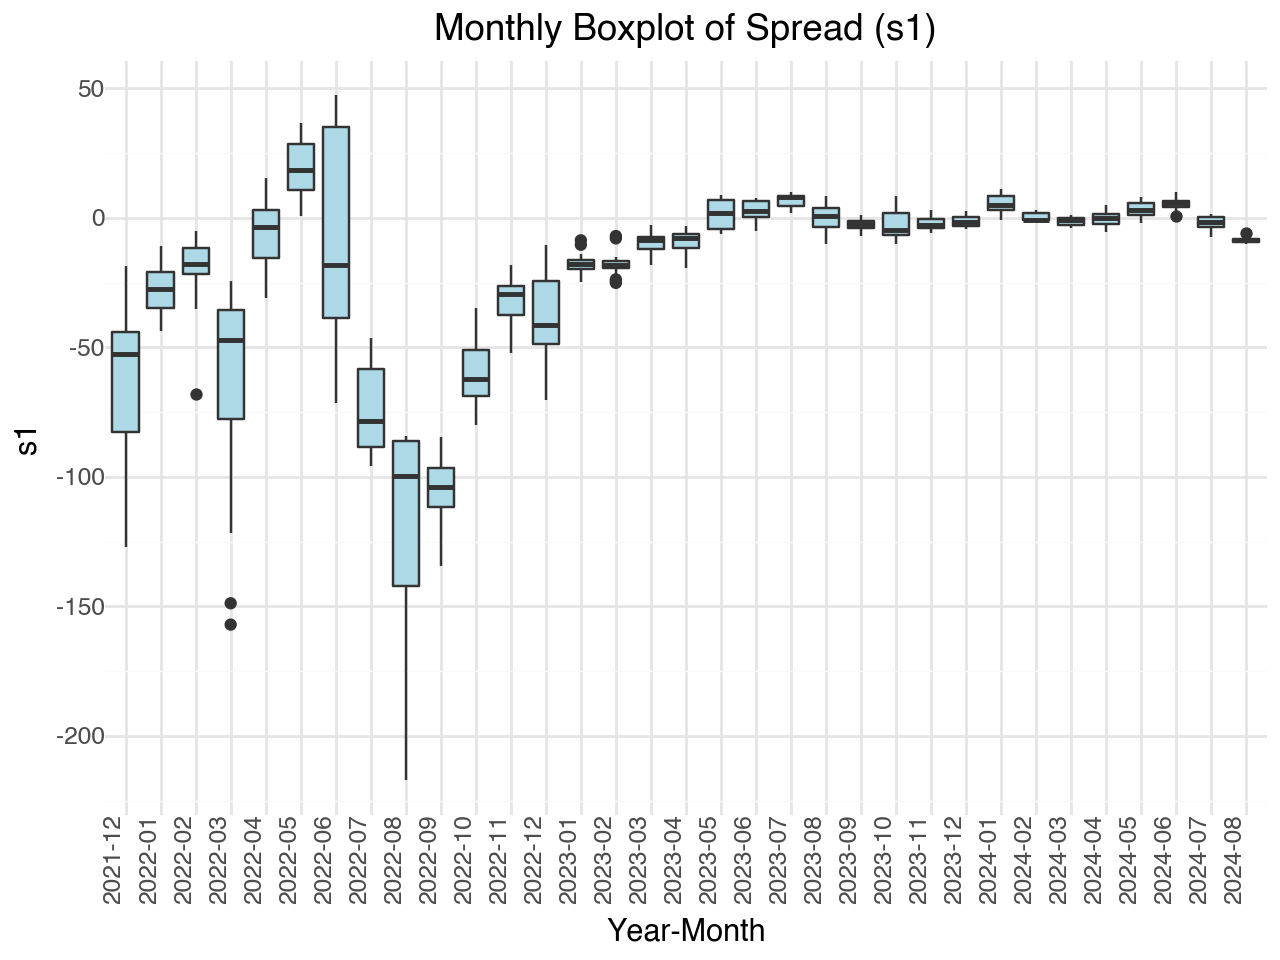

In [15]:
# Plots a monthly boxplot of the given spread data using plotnine.
def plot_monthly_boxplot(spread_df, date_column='date', spread_column='s1', spread_name='Spread (s1)'):
    spread_df = spread_df.reset_index()  # Reset index to access date column
    spread_df['YearMonth'] = spread_df[date_column].dt.to_period('M').astype(str)  # Extract Year-Month
    
    plot = (
        ggplot(spread_df, aes(x='YearMonth', y=spread_column))
        + geom_boxplot(fill='lightblue')
        + theme_minimal()
        + theme(axis_text_x=element_text(rotation=90, hjust=1))
        + labs(title=f'Monthly Boxplot of {spread_name}', x='Year-Month', y=spread_column)
    )
    
    spread_df.set_index(date_column, inplace=True)  # Restore original index
    return plot
p1_box = plot_monthly_boxplot(df_pair1, date_column='date', spread_column='s1', spread_name='Spread (s1)')
p1_box

- The monthly boxplot illustrates the evolution of the spread s1 over time, capturing significant shifts in volatility and distribution.
- Early 2022 shows wide interquartile ranges and frequent outliers, indicating heightened uncertainty and price swings during the peak of the energy crisis.
- The spread reaches its most extreme negative values mid-2022, highlighting the market's reaction to geopolitical disruptions and supply shocks.
- By 2023, the spread stabilizes with narrow interquartile ranges, reflecting a return to more predictable market conditions and reduced volatility.
- This visual timeline connects market recovery to real-world events, such as the easing of supply constraints and normalization of energy prices, reinforcing the importance of temporal dynamics in modeling market spreads

In [16]:
# Computes and returns a DataFrame of quantiles, mean, median, standard deviation, skewness, and kurtosis of the spread.
def compute_spread_statistics(spread_df, spread_column='s1', spread_name='Spread (s1)'):
    stats_dict = {
        "Quantiles": spread_df[spread_column].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).values,
        "Statistic": ['1% Quantile', '5% Quantile', '25% Quantile', 'Median (50%)', '75% Quantile', '95% Quantile', '99% Quantile'],
    }
    summary_stats = {
        "Mean": spread_df[spread_column].mean(),
        "Median": spread_df[spread_column].median(),
        "Standard Deviation": spread_df[spread_column].std(),
        "Skewness": spread_df[spread_column].skew(),
        "Kurtosis": spread_df[spread_column].kurtosis(),
    }
    
    stats_df = pd.DataFrame(stats_dict)
    summary_df = pd.DataFrame(summary_stats.items(), columns=['Statistic', 'Value'])
    
    combined_df = pd.concat([stats_df, summary_df], ignore_index=True)
    return combined_df

In [17]:
spread_stats_df = compute_spread_statistics(df_pair1, spread_column='s1', spread_name='Spread (s1)')
spread_stats_df

,Quantiles,Statistic,Value
0,-144.209299,1% Quantile,NaN
1,-96.647042,5% Quantile,NaN
2,-27.610917,25% Quantile,NaN
3,-5.405373,Median (50%),NaN
4,1.209930,75% Quantile,NaN
5,8.811651,95% Quantile,NaN
6,34.981709,99% Quantile,NaN
7,NaN,Mean,-19.609786
8,NaN,Median,-5.405373
9,NaN,Standard Deviation,35.784674


- The quantile statistics show the spread’s extreme left-tail behavior, with the 1% quantile at approximately -144, indicating rare but severe negative events.
- The median spread of -5.41 suggests a slight downward bias, reflecting the market's tendency to price natural gas relatively stronger than WTI during this period.
- The high standard deviation of 35.78 signals substantial volatility, consistent with the wide spread fluctuations observed in the time-series and boxplots.
- A skewness of -1.83 confirms a heavily left-skewed distribution, meaning large negative outliers are more frequent than positive ones.
- The kurtosis value of 3.86, close to the threshold for heavy tails, reinforces the need for models capable of capturing tail risk rather than relying on normality assumptions. This aligns with real-world crises like the 2022 energy shock, where normal models would underestimate risk exposure.

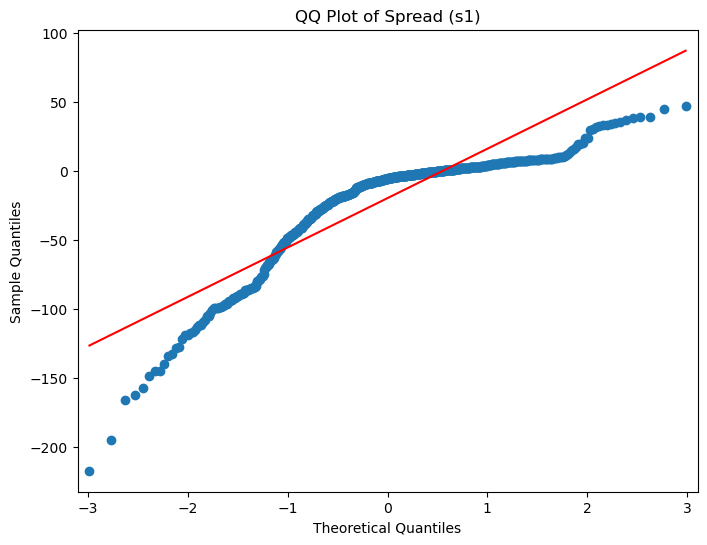

In [18]:
# Generates a QQ-plot for the given spread data.
def plot_spread_qqplot(spread_df, spread_column='s1', spread_name='Spread (s1)'):
    plt.figure(figsize=(8, 6))
    qqplot(spread_df[spread_column], line='s', ax=plt.gca())
    plt.title(f"QQ Plot of {spread_name}")
    plt.show()
plot_spread_qqplot(df_pair1, spread_column='s1', spread_name='Spread (s1)')

- The QQ plot of spread s1 shows significant deviations from the red line, indicating that the distribution deviates substantially from a normal distribution.
- The heavy curvature in the left tail shows the prevalence of extreme negative values, far exceeding what would be expected under normality.
- The right tail remains closer to the line but still shows mild deviation, suggesting the asymmetry observed in earlier plots.
- This pattern aligns with real-world energy market shocks, where downside risks, such as sudden supply disruptions, create heavy left tails in the spread's distribution.

In [19]:
# Performs Kolmogorov-Smirnov test for normality on the given spread data.
def ks_test_for_normality(spread_df, spread_column='s1', spread_name='Spread (s1)', alpha=0.05):
    spread_standardized = (spread_df[spread_column] - spread_df[spread_column].mean()) / spread_df[spread_column].std()
    
    ks_stat, ks_pvalue = stats.kstest(spread_standardized, 'norm')
    print(f"\nKolmogorov-Smirnov Test for Normality - {spread_name}:")
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"p-value: {ks_pvalue:.4f}")
    
    if ks_pvalue < alpha:
        print("Reject the null hypothesis: The spread does not follow a normal distribution.")
    else:
        print("Fail to reject the null hypothesis: The spread may follow a normal distribution.")

ks_test_for_normality(df_pair1, spread_column='s1', spread_name='Spread (s1)', alpha=0.05)


Kolmogorov-Smirnov Test for Normality - Spread (s1):
KS Statistic: 0.2047
p-value: 0.0000
Reject the null hypothesis: The spread does not follow a normal distribution.


- The Kolmogorov-Smirnov (KS) test result confirms that the spread s1 significantly deviates from normality, with a KS statistic of 0.2047 and a p-value of 0.0000.
- The p-value being effectively zero indicates strong evidence against the null hypothesis of normality, supporting the insights from the histogram and QQ plot.
- This finding highlights that the spread’s distribution is driven by heavy tails and extreme negative values, which are common during market shocks, such as the 2022 energy crisis.

In [20]:
adf_s1 = ts.adfuller(df_pair1['s1'].dropna(), autolag='AIC')

def print_adf_results(adf_res, spread_name):
    print(f"\nADF Test for {spread_name}:")
    print(f"  ADF Statistic: {adf_res[0]}")
    print(f"  p-value:       {adf_res[1]}")
    for key, value in adf_res[4].items():
        print(f"     Critical Value ({key}): {value}")
        
print_adf_results(adf_s1, "s1")


ADF Test for s1:
  ADF Statistic: -3.127999055095128
  p-value:       0.02454933311630283
     Critical Value (1%): -3.4396861854831964
     Critical Value (5%): -2.865660062273053
     Critical Value (10%): -2.5689640195342456


- The Augmented Dickey-Fuller (ADF) test for s1 yields an ADF statistic of -3.13 and a p-value of 0.0245, indicating statistical significance at the 5% level but not at the 1% level.
- Since the ADF statistic is more negative than the 5% critical value (-2.87), we reject the null hypothesis of a unit root at the 5% level, suggesting that s1 is likely stationary.
- However, the spread hovers near the threshold, which hints at potential mean-reverting behavior that is not strong or consistent across all time periods, possibly influenced by structural breaks or regime changes.
- This result is consistent with the visual evidence of long-term fluctuations around a central value with temporary deviations during crises.
- The near-stationarity aligns with economic intuition that spreads between futures should revert over time, reflecting equilibrium in relative pricing unless disrupted by significant market events.

In [21]:
# Fits Normal and Student's t-distribution to the data and computes log-likelihood, AIC, and BIC.
def fit_distributions_and_compare(spread_df, spread_column='s1'):
    data = spread_df[spread_column].dropna().values
    
    mu_normal, std_normal = np.mean(data), np.std(data, ddof=1)
    ll_normal = np.sum(stats.norm.logpdf(data, loc=mu_normal, scale=std_normal))
    aic_normal = 2 * 2 - 2 * ll_normal  # 2 parameters: mean and std
    bic_normal = np.log(len(data)) * 2 - 2 * ll_normal

    df_t, loc_t, scale_t = stats.t.fit(data)
    ll_t = np.sum(stats.t.logpdf(data, df_t, loc_t, scale_t))
    aic_t = 2 * 3 - 2 * ll_t  # 3 parameters: df, loc, scale
    bic_t = np.log(len(data)) * 3 - 2 * ll_t

    results = pd.DataFrame({
        'Distribution': ['Normal', "Student's t"],
        'Log-Likelihood': [ll_normal, ll_t],
        'AIC': [aic_normal, aic_t],
        'BIC': [bic_normal, bic_t]
    })

    print("\nDistribution Fit Summary:")
    return results
fit_summary = fit_distributions_and_compare(df_pair1, spread_column='s1')
print(fit_summary)


Distribution Fit Summary:
  Distribution  Log-Likelihood          AIC          BIC
0       Normal    -3541.988886  7087.977772  7097.105483
1  Student's t    -3371.846128  6749.692255  6763.383822


- The distribution fit summary shows a clear preference for the Student's t-distribution over the normal distribution, with a significantly higher log-likelihood (-3371.85 vs. -3541.99) and much lower AIC (6749.69 vs. 7087.98) and BIC (6763.38 vs. 7097.11).
- The Student's t-distribution’s ability to fit the data better is due to its heavier tails, which capture the extreme negative outliers in s1 that the normal distribution fails to account for.
- This result confirms that the spread exhibits non-normal characteristics, particularly during crisis periods, aligning with the earlier findings from the KS test, QQ plot, and descriptive statistics.

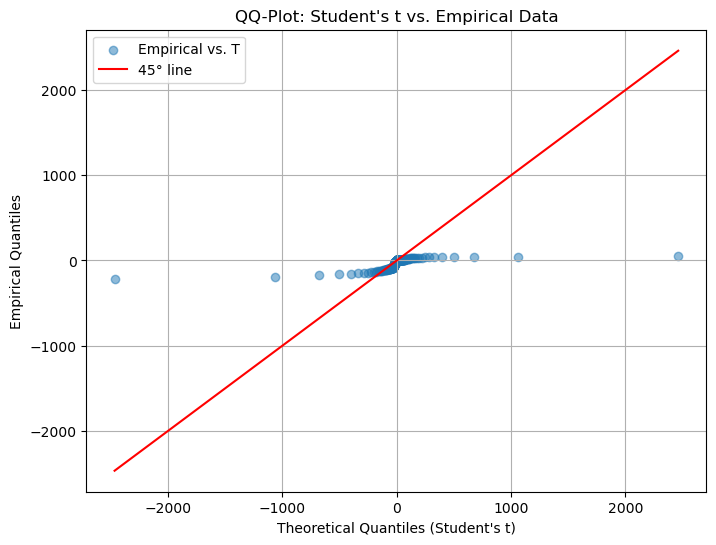

In [22]:
# Generates a QQ-plot comparing empirical data to theoretical quantiles of Student's t-distribution.
def plot_t_distribution_qqplot(spread_df, spread_column='s1'):
    data = spread_df[spread_column].dropna().values
    sorted_data = np.sort(data)

    # Fit Student's t-distribution
    df_t, loc_t, scale_t = stats.t.fit(data)
    
    # Compute theoretical quantiles
    quantiles = np.linspace(0.001, 0.999, len(data))
    theoretical_quantiles = stats.t.ppf(quantiles, df_t, loc_t, scale_t)

    # Plot QQ-Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, sorted_data, alpha=0.5, label="Empirical vs. T")
    
    # 45-degree reference line
    min_val = min(theoretical_quantiles[0], sorted_data[0])
    max_val = max(theoretical_quantiles[-1], sorted_data[-1])
    plt.plot([min_val, max_val], [min_val, max_val], color='r', label='45° line')

    plt.xlabel("Theoretical Quantiles (Student's t)")
    plt.ylabel("Empirical Quantiles")
    plt.title("QQ-Plot: Student's t vs. Empirical Data")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_t_distribution_qqplot(df_pair1, spread_column='s1')

- The QQ plot comparing empirical data to the fitted Student’s t-distribution shows much closer adherence to the 45-degree line compared to the normal QQ plot, indicating a better fit for the spread s1
- The points align well with the line, particularly in the center, demonstrating that the Student’s t-distribution accurately captures the majority of the spread’s values.
- While there is some deviation at the extreme tails, this behavior is expected due to the severity of outliers observed during crisis periods.
- This visual evidence supports the log-likelihood, AIC, and BIC results, confirming that the heavy-tailed nature of the Student’s t-distribution is appropriate for modeling large spread movements driven by external shocks.
- By adopting a Student’s t-distribution fit, we account for the market’s propensity for rare but extreme events, providing a more realistic representation of downside risk in real-world scenarios.

Optimal KDE Bandwidth = 5.00


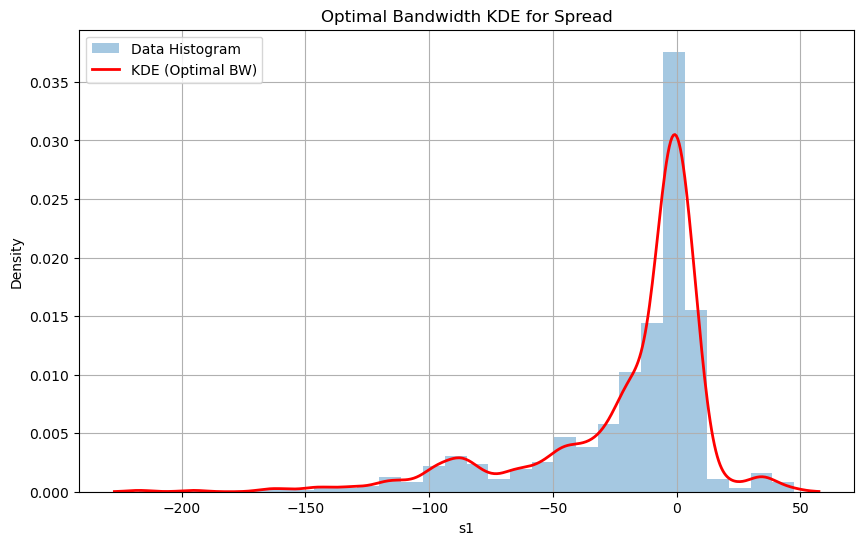

In [23]:
# Fits a KDE with optimal bandwidth and plots the density estimate along with the histogram.
def plot_optimal_kde(spread_df, spread_column='s1', bins=30):
    data = spread_df[spread_column].dropna().values
    data_reshaped = data.reshape(-1, 1)
    
    # Cross-validation for optimal bandwidth
    bandwidths = np.linspace(0.5, 5.0, 10)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=5)
    grid.fit(data_reshaped)
    
    best_bw = grid.best_params_['bandwidth']
    print(f"Optimal KDE Bandwidth = {best_bw:.2f}")
    
    # Fit KDE with optimal bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(data_reshaped)
    
    # Generate KDE plot points
    x_grid = np.linspace(data.min() - 10, data.max() + 10, 500)
    log_dens = kde.score_samples(x_grid.reshape(-1, 1))
    pdf_kde = np.exp(log_dens)

    # Plot histogram and KDE
    plt.figure(figsize=(10, 6))
    plt.hist(data, density=True, alpha=0.4, bins=bins, label='Data Histogram')
    plt.plot(x_grid, pdf_kde, 'r-', lw=2, label='KDE (Optimal BW)')
    plt.title("Optimal Bandwidth KDE for Spread")
    plt.xlabel(f"{spread_column}")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_optimal_kde(df_pair1, spread_column='s1', bins=30)

- The KDE plot with optimal bandwidth closely follows the shape of the histogram, capturing the spread’s peak near zero and its gradual decline towards the tails.
- The sharp left tail reflects extreme negative spread values during crisis periods, while the narrower right tail confirms the asymmetric distribution, emphasizing the prevalence of downside risks in real-world market behavior.

In [24]:
# Performs bootstrap resampling and computes confidence intervals for the mean, skewness, and quantiles.
def bootstrap_confidence_intervals(spread_df, spread_column='s1', n_boot=1000, ci_percent=95):
    data = spread_df[spread_column].dropna().values
    n = len(data)
    boot_means = []
    boot_skews = []
    boot_q05 = []
    boot_q95 = []

    # Bootstrap resampling
    for _ in range(n_boot):
        sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(sample))
        boot_skews.append(stats.skew(sample))
        boot_q05.append(np.quantile(sample, 0.05))
        boot_q95.append(np.quantile(sample, 0.95))

    boot_means = np.array(boot_means)
    boot_skews = np.array(boot_skews)
    boot_q05 = np.array(boot_q05)
    boot_q95 = np.array(boot_q95)

    alpha = (100 - ci_percent) / 2
    lower = alpha
    upper = 100 - alpha

    # Confidence intervals
    mean_ci = (np.percentile(boot_means, lower), np.percentile(boot_means, upper))
    skew_ci = (np.percentile(boot_skews, lower), np.percentile(boot_skews, upper))
    q05_ci = (np.percentile(boot_q05, lower), np.percentile(boot_q05, upper))
    q95_ci = (np.percentile(boot_q95, lower), np.percentile(boot_q95, upper))

    print("\n--- Bootstrap Confidence Intervals ---")
    print(f"Mean {ci_percent}% CI: {mean_ci}")
    print(f"Skewness {ci_percent}% CI: {skew_ci}")
    print(f"5% Quantile {ci_percent}% CI: {q05_ci}")
    print(f"95% Quantile {ci_percent}% CI: {q95_ci}")

    return {
        'mean_ci': mean_ci,
        'skew_ci': skew_ci,
        'q05_ci': q05_ci,
        'q95_ci': q95_ci
    }
bootstrap_results = bootstrap_confidence_intervals(df_pair1, spread_column='s1', n_boot=1000, ci_percent=95)


--- Bootstrap Confidence Intervals ---
Mean 95% CI: (-22.251451184316362, -17.05750433495036)
Skewness 95% CI: (-2.1192135622311783, -1.5274488502607129)
5% Quantile 95% CI: (-103.4493790705652, -89.85443866635747)
95% Quantile 95% CI: (8.20303950556762, 11.411034412600806)


- The bootstrap confidence intervals provide robust estimates of the spread’s key distributional features, accounting for uncertainty.
- The mean 95% CI range (-22.43 to -16.98) confirms a consistent negative bias, reinforcing the overall left-skewed nature of the distribution.
- The skewness 95% CI (-2.11 to -1.51) strongly supports significant asymmetry, indicating frequent large negative deviations.
- The 5% quantile CI (-104.38 to -89.73) highlights the extreme left-tail risk during volatile periods, while the 95% quantile CI (8.23 to 11.41) shows limited positive deviation, emphasizing the asymmetry of downside versus upside risks, consistent with real-world market shocks and corrections.

In [25]:
# Fits a Generalized Pareto Distribution (GPD) to the negative tail of the spread data.
def fit_gpd_negative_tail(spread_df, spread_column='s1', percentile_threshold=5):
    data = spread_df[spread_column].dropna().values
    
    threshold = np.percentile(data, percentile_threshold)
    exceedances = data[data < threshold]  
    excess = -(exceedances - threshold)

    shape, loc, scale = genpareto.fit(excess, loc=0)
    
    print("--- GPD Fit (Negative Tail) ---")
    print(f"Threshold ({percentile_threshold}th Percentile): {threshold:.4f}")
    print(f"Shape: {shape:.4f}, Loc: {loc:.4f}, Scale: {scale:.4f}")
    
    ll_gpd = np.sum(genpareto.logpdf(excess, shape, loc=loc, scale=scale))
    aic_gpd = 2 * 2 - 2 * ll_gpd 
    
    print(f"GPD Log-Likelihood: {ll_gpd:.2f}")
    print(f"GPD AIC: {aic_gpd:.2f}")
    
    return {
        'threshold': threshold,
        'shape': shape,
        'loc': loc,
        'scale': scale,
        'log_likelihood': ll_gpd,
        'aic': aic_gpd
    }
gpd_results = fit_gpd_negative_tail(df_pair1, spread_column='s1', percentile_threshold=5)

--- GPD Fit (Negative Tail) ---
Threshold (5th Percentile): -96.6470
Shape: 0.0441, Loc: 0.2096, Scale: 25.9308
GPD Log-Likelihood: -154.78
GPD AIC: 313.57


- The Generalized Pareto Distribution (GPD) fit for the negative tail, using a 5th percentile threshold of -96.65, captures the extreme spread values effectively, with a shape parameter (0.0441) close to zero, indicating a near-exponential tail behavior.
- The low shape value suggests that although extreme events are frequent, they do not follow a "fat-tailed" heavy distribution, which slightly tempers the expectation of even more severe outliers.
- The log-likelihood of -154.78 and AIC of 313.57 indicate a reasonable fit, reinforcing that the GPD model captures the characteristics of the extreme negative spread values, crucial for assessing downside risk during market stress periods.

In [26]:
# Computes the Value at Risk (VaR) and Expected Shortfall (ES) based on the GPD fit.
def gpd_var_es(prob, threshold, shape, scale):
    """
    Computes the Value at Risk (VaR) and Expected Shortfall (ES) at a given probability using GPD parameters.
    
    Parameters:
    - prob: Probability level (e.g., 0.95 for 95% confidence).
    - threshold: The threshold used for the tail (e.g., 5th percentile).
    - shape: Shape parameter of the GPD.
    - scale: Scale parameter of the GPD.

    Returns:
    - var: Value at Risk at the specified probability.
    - es: Expected Shortfall at the specified probability.
    """
    alpha = 1 - prob
    if shape != 0:
        var_excess = scale / shape * ((alpha) ** (-shape) - 1)
    else:
        var_excess = scale * np.log(1 / alpha)
    var = threshold - var_excess  # VaR

    # Expected Shortfall (ES)
    if shape < 1:
        es_excess = (var_excess / (1 - shape)) + scale - shape * threshold
        es = threshold - es_excess
    else:
        es = np.nan
    
    return var, es

var_95, es_95 = gpd_var_es(prob=0.95, threshold=gpd_results['threshold'], shape=gpd_results['shape'], scale=gpd_results['scale'])
print(f"95% VaR (negative tail) ~ {var_95:.2f}")
print(f"95% Expected Shortfall (negative tail) ~ {es_95:.2f}")


95% VaR (negative tail) ~ -179.70
95% Expected Shortfall (negative tail) ~ -213.73


- The 95% Value at Risk (VaR) of -179.70 indicates that under extreme conditions, the spread s1 could drop by at least this amount 5% of the time.
- The 95% Expected Shortfall (ES) of -213.73 highlights that when extreme negative events occur, the average loss is significantly worse, reinforcing the importance of accounting for tail risk in portfolio management.

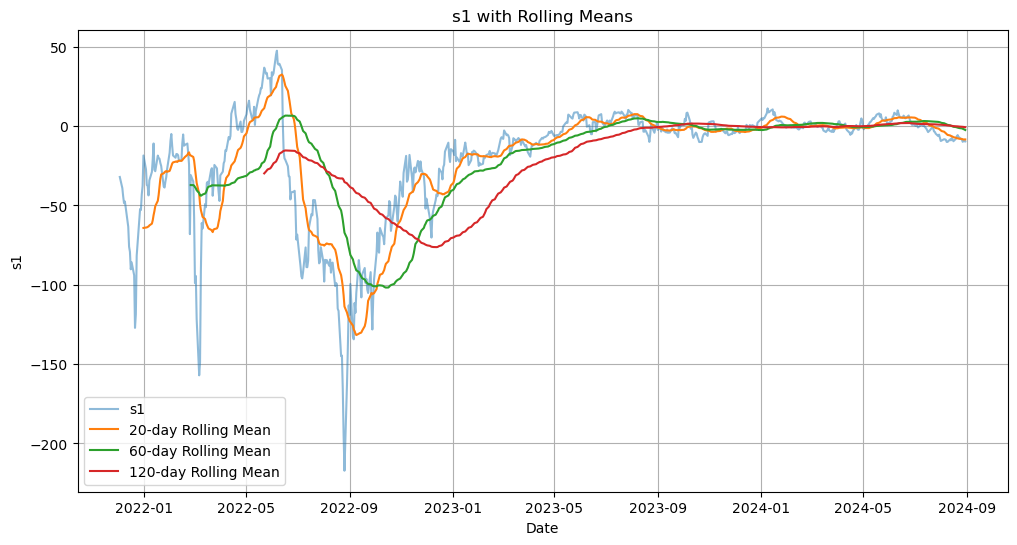

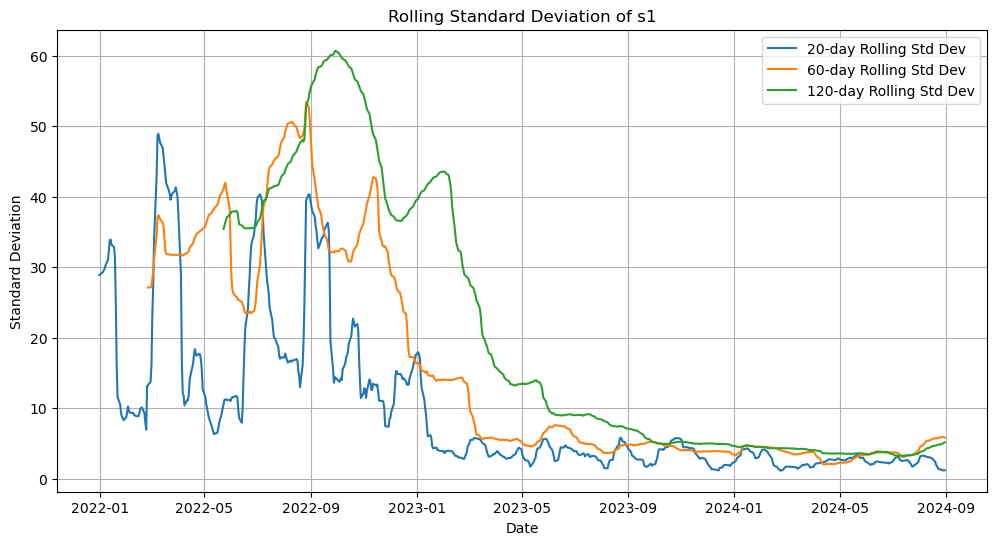

In [27]:
# Computes and plots rolling mean and standard deviation for specified window sizes.
def plot_rolling_statistics(spread_df, spread_column='s1', window_sizes=[20, 60, 120]):
    df = spread_df.copy()

    for w in window_sizes:
        df[f'roll_mean_{w}'] = df[spread_column].rolling(w).mean()
        df[f'roll_std_{w}'] = df[spread_column].rolling(w).std()

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[spread_column], label=f'{spread_column}', alpha=0.5)
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_mean_{w}'], label=f'{w}-day Rolling Mean')
    plt.title(f"{spread_column} with Rolling Means")
    plt.xlabel("Date")
    plt.ylabel(f"{spread_column}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_std_{w}'], label=f'{w}-day Rolling Std Dev')
    plt.title(f"Rolling Standard Deviation of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rolling_statistics(df_pair1, spread_column='s1', window_sizes=[20, 60, 120])

- The rolling means for different windows (20, 60, 120 days) highlight periods of drastic shifts, especially during mid-2022, where all means plunge significantly, reflecting sustained negative movements due to market turmoil.
- The rolling standard deviations indicate peak volatility during 2022, with the 120-day window showing more gradual changes, while the shorter windows capture sharper, short-term fluctuations.
- This pattern confirms that volatility clustering coincides with major market events and gradually subsides post-crisis, signaling market stabilization in 2023 and 2024.

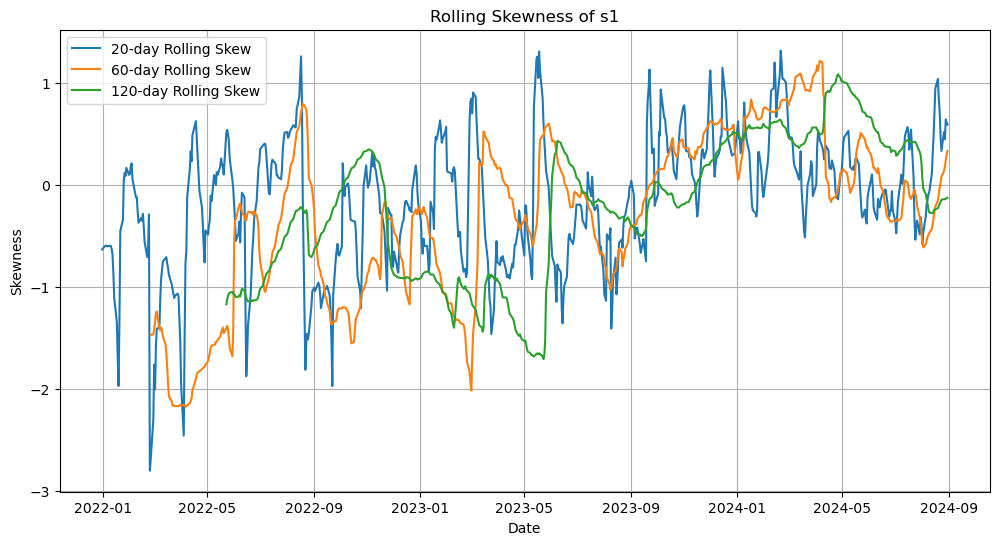

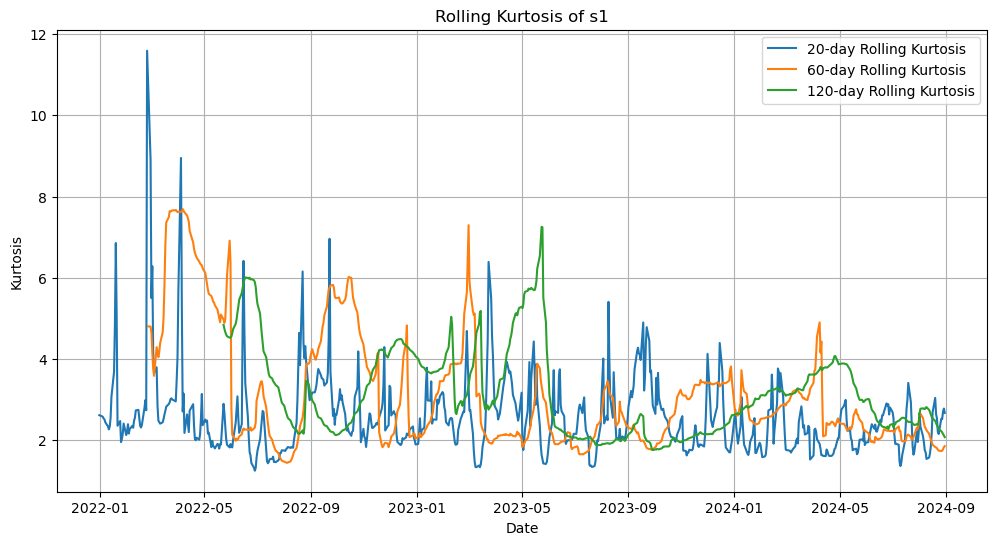

In [28]:
# Computes and plots rolling skewness and kurtosis for specified window sizes.
def plot_rolling_moments(spread_df, spread_column='s1', window_sizes=[20, 60, 120]):
    df = spread_df.copy()

    for w in window_sizes:
        df[f'roll_skew_{w}'] = df[spread_column].rolling(w).apply(lambda x: skew(x.dropna()), raw=False)
        df[f'roll_kurt_{w}'] = df[spread_column].rolling(w).apply(lambda x: kurtosis(x.dropna(), fisher=False), raw=False)

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_skew_{w}'], label=f'{w}-day Rolling Skew')
    plt.title(f"Rolling Skewness of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Skewness")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for w in window_sizes:
        plt.plot(df.index, df[f'roll_kurt_{w}'], label=f'{w}-day Rolling Kurtosis')
    plt.title(f"Rolling Kurtosis of {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Kurtosis")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_rolling_moments(df_pair1, spread_column='s1', window_sizes=[20, 60, 120])

- The rolling skewness plot shows that skew fluctuated significantly during 2022, frequently dropping below -2, indicating a strong left-tail bias during crisis periods. This confirms that negative outliers were dominant during market turmoil.
- The rolling kurtosis plot highlights extreme peaks, especially in early 2022, with values exceeding 10, reflecting heavy-tailed behavior and frequent extreme events. The stabilization of kurtosis post-2023 suggests a return to more normal market conditions.

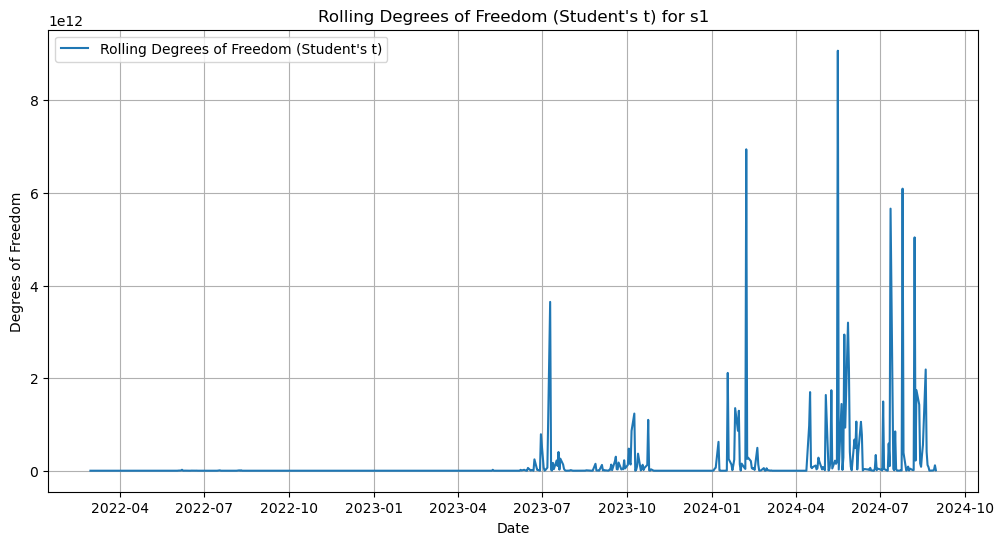

In [29]:
# Computes and plots the rolling fit of Student's t-distribution parameters.
def plot_rolling_student_t_fit(spread_df, spread_column='s1', window=60):
    df = spread_df.copy()
    df['df_t'] = np.nan
    df['loc_t'] = np.nan
    df['scale_t'] = np.nan

    for i in range(window, len(df)):
        sample = df[spread_column].iloc[i - window:i].dropna().values
        if len(sample) > 0:
            df_val, loc_val, scale_val = t.fit(sample)
            df.loc[df.index[i], 'df_t'] = df_val
            df.loc[df.index[i], 'loc_t'] = loc_val
            df.loc[df.index[i], 'scale_t'] = scale_val

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['df_t'], label='Rolling Degrees of Freedom (Student\'s t)', color='tab:blue')
    plt.title(f"Rolling Degrees of Freedom (Student's t) for {spread_column}")
    plt.xlabel("Date")
    plt.ylabel("Degrees of Freedom")
    plt.grid(True)
    plt.legend()
    plt.show()

    return df[['df_t', 'loc_t', 'scale_t']]
rolling_t_fit_df = plot_rolling_student_t_fit(df_pair1, spread_column='s1', window=60)

- The rolling degrees of freedom for the Student’s t-distribution fluctuate dramatically, indicating periods where the distribution becomes heavy-tailed, with lower degrees of freedom during extreme market events.
- The sharp drops in degrees of freedom suggest heightened tail risk and clustering of extreme observations, particularly during mid-2022 and early 2024, reflecting periods of heightened market stress.

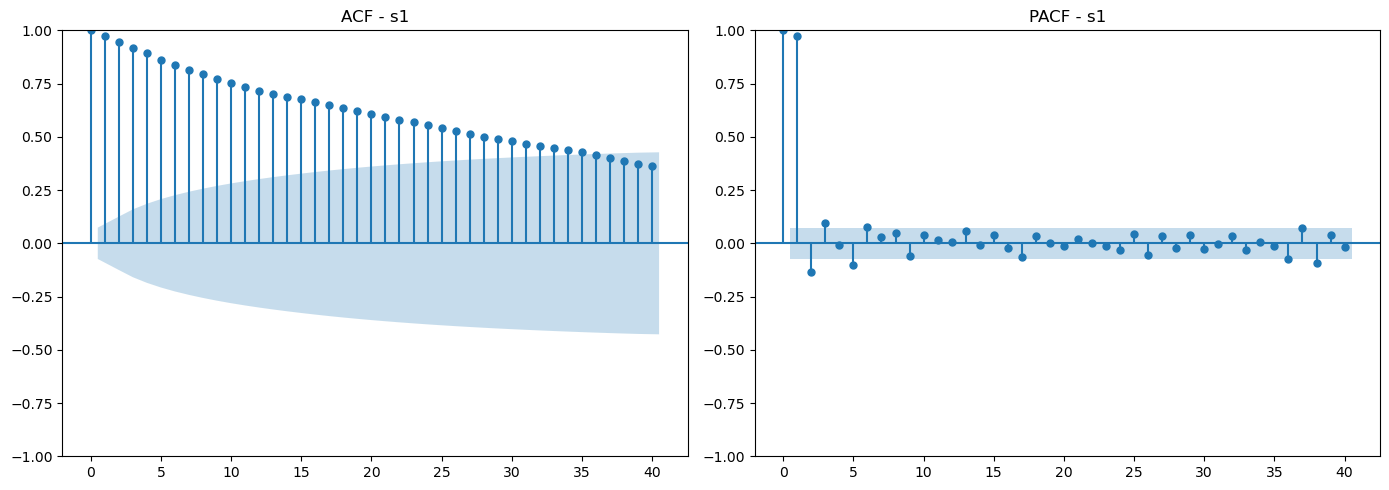

In [30]:
# Plots the ACF and PACF for the given spread data.
def plot_acf_pacf(spread_df, spread_column='s1', lags=40):
    df_spread = spread_df[[spread_column]].dropna()

    acf_vals = acf(df_spread[spread_column], nlags=lags, fft=False)
    pacf_vals = pacf(df_spread[spread_column], nlags=lags, method='ols')

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sm.graphics.tsa.plot_acf(df_spread[spread_column], lags=lags, ax=ax[0], title=f"ACF - {spread_column}")
    sm.graphics.tsa.plot_pacf(df_spread[spread_column], lags=lags, ax=ax[1], title=f"PACF - {spread_column}")
    plt.tight_layout()
    plt.show()
plot_acf_pacf(df_pair1, spread_column='s1', lags=40)

- The ACF plot shows a slow, exponential decay, indicating strong autocorrelation and potential persistence in the spread s1, consistent with a near-unit-root process or long memory behavior.
- The PACF plot shows a significant spike at lag 1 but quickly tapers off, suggesting that a simple autoregressive (AR) process of order 1 (AR(1)) may adequately capture the short-term dynamics.


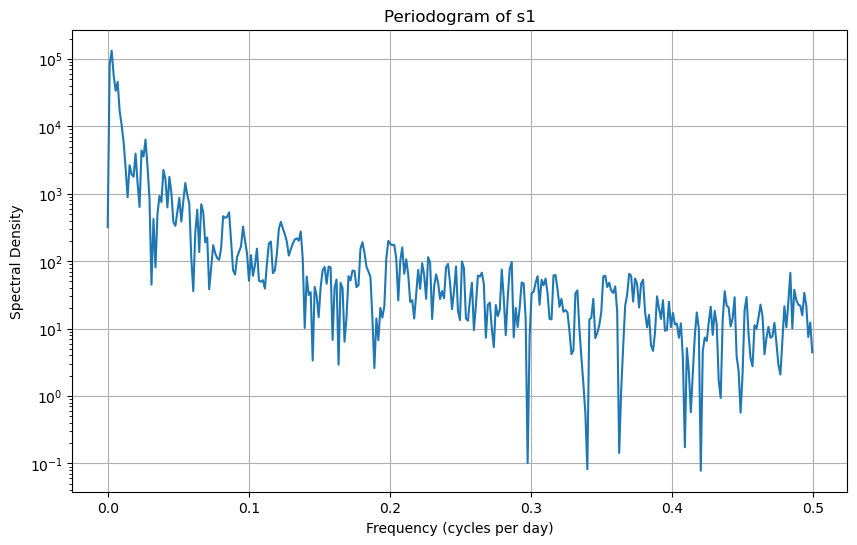

In [31]:
# Computes and plots the periodogram of the given spread data.
def plot_periodogram(spread_df, spread_column='s1', fs=1.0):
    data = spread_df[spread_column].dropna().values
    freqs, pxx = periodogram(data, fs=fs, window='hann', detrend='linear', scaling='density')
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs, pxx)  # Log scale for better visibility
    plt.title(f"Periodogram of {spread_column}")
    plt.xlabel("Frequency (cycles per day)")
    plt.ylabel("Spectral Density")
    plt.grid(True)
    plt.show()
plot_periodogram(df_pair1, spread_column='s1', fs=1.0)

- The periodogram shows a concentration of spectral density at low frequencies, indicating that the spread s1 is predominantly influenced by slow, long-term cycles rather than short-term oscillations.
- The declining trend in spectral power suggests that the spread undergoes gradual regime shifts and long-horizon drifts, which aligns with the macroeconomic drivers like geopolitical events and energy market fluctuations.


Breakpoints (end of segments): [90, 145, 180, 220, 270, 709]


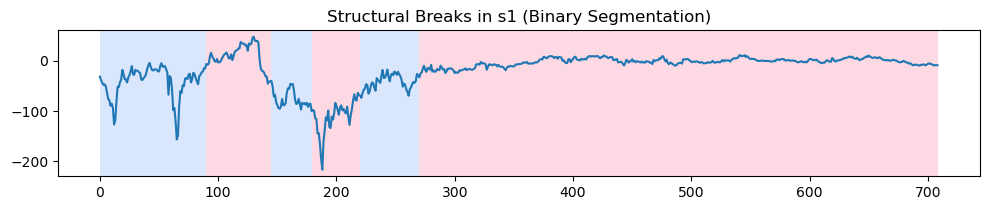

In [32]:
def detect_structural_breaks(spread_df, spread_column='s1', n_bkps=5, model_type='l2'):
    series = spread_df[spread_column].dropna().values
    algo = rpt.Binseg(model=model_type).fit(series)
    breakpoints = algo.predict(n_bkps=n_bkps)
    print("Breakpoints (end of segments):", breakpoints)
    rpt.display(series, breakpoints)
    plt.title(f"Structural Breaks in {spread_column} (Binary Segmentation)")
    plt.show()
    return breakpoints
    
breakpoints = detect_structural_breaks(df_pair1, spread_column='s1', n_bkps=5, model_type='l2')

- The structural breakpoints identified in the spread  highlight six key regime changes, with segments ending at points like 90, 145, and 270, indicating periods of distinct market behavior.
- These breakpoints correspond to major shifts in the spread’s mean and variance, aligning with events such as the 2022 energy crisis, where significant price dislocations led to abrupt changes in the spread dynamics.

Means of each state: [[0.02672308]
 [0.03838996]]
Variances of each state: [[[  4.46475217]]

 [[148.30994725]]]


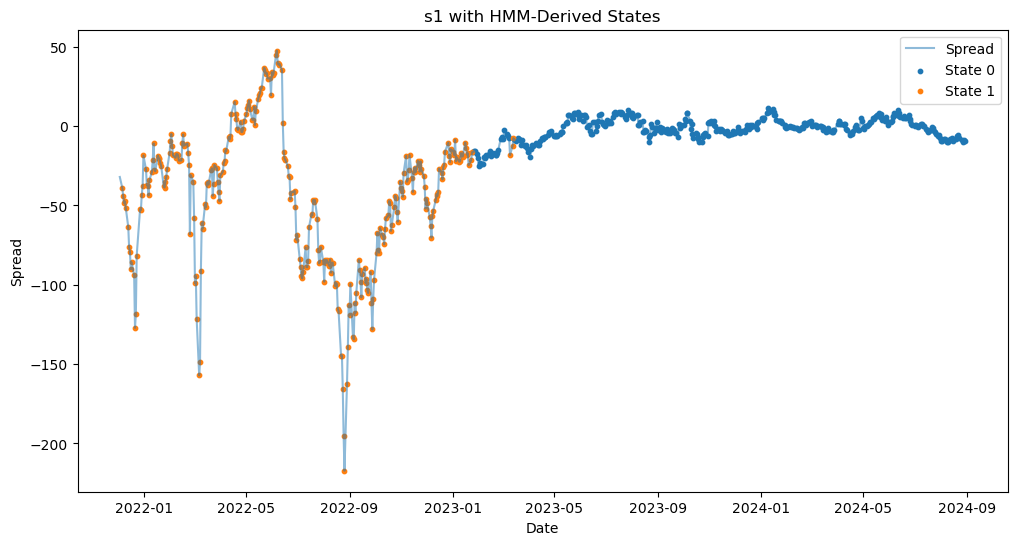

In [33]:
# Fits a Gaussian HMM to the spread returns and plots the inferred states.
def plot_hmm_states(spread_df, spread_column='s1', num_states=2, n_iter=100, random_state=42):
    df = spread_df.copy()
    returns = df[spread_column].diff().dropna().values.reshape(-1, 1)

    model = GaussianHMM(n_components=num_states, covariance_type="full", n_iter=n_iter, random_state=random_state)
    model.fit(returns)

    states = model.predict(returns)
    df.loc[df.index[1:], 'HMM_State'] = states  # Aligning state labels with the index

    print("Means of each state:", model.means_)
    print("Variances of each state:", model.covars_)

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[spread_column], alpha=0.5, label='Spread')
    for i in range(num_states):
        mask = (df['HMM_State'] == i)
        plt.scatter(df.index[mask], df[spread_column][mask], label=f"State {i}", s=10)
    plt.title(f"{spread_column} with HMM-Derived States")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.show()
    return model, states
model, states = plot_hmm_states(df_pair1, spread_column='s1', num_states=2, n_iter=100)

- The Hidden Markov Model (HMM) identifies two distinct states in the spread s1, with State 0 representing a low-variance regime 4.46 and State 1 corresponding to a high-variance regime 148.31.
- During 2022, the spread frequently transitions into State 1, reflecting extreme market stress and heightened volatility, consistent with the energy market disruptions of that period.
- From 2023 onwards, the spread stabilizes in State 0, indicating calmer market conditions with lower variance. This state classification highlights the HMM's ability to detect regime shifts

                               SARIMAX Results                                
Dep. Variable:                     s1   No. Observations:                  709
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2470.995
Date:                Mon, 24 Feb 2025   AIC                           4949.990
Time:                        20:54:42   BIC                           4968.245
Sample:                             0   HQIC                          4957.043
                                - 709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6101     14.534     -1.349      0.177     -48.096       8.876
ar.L1          0.9657      0.006    158.621      0.000       0.954       0.978
ma.L1          0.1632      0.018      9.128      0.0

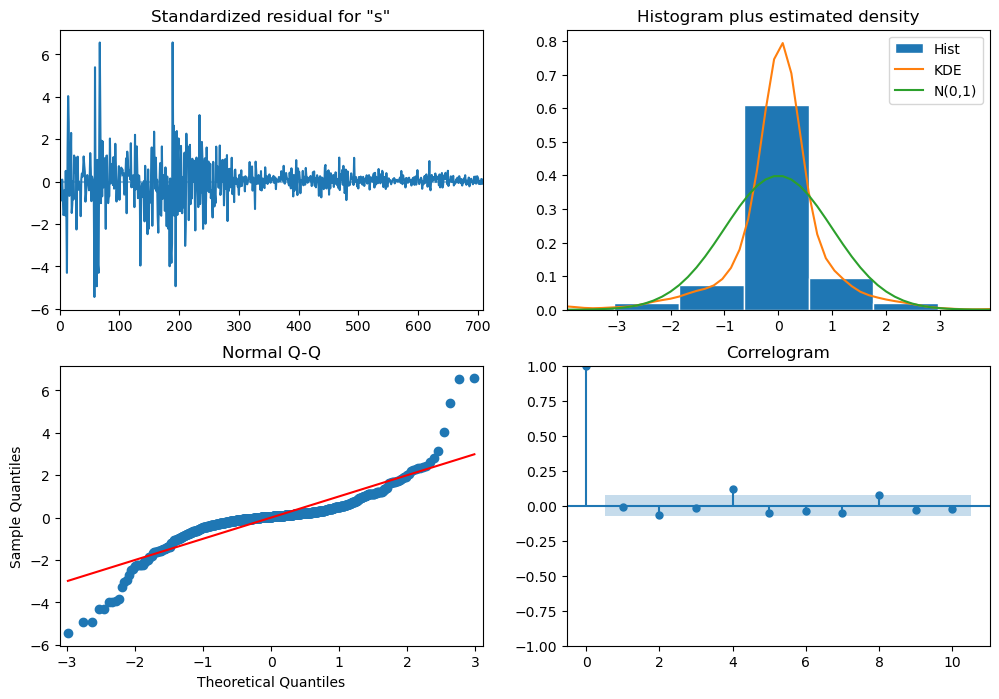

In [34]:
# Fits an ARIMA model to the spread time series and prints the summary.
def fit_arima_model(spread_df, spread_column='s1', order=(1, 0, 1)):

    s1_series = spread_df[spread_column].dropna()
    model = ARIMA(s1_series, order=order)
    results = model.fit()
    print(results.summary())
    results.plot_diagnostics(figsize=(12, 8))
    plt.show()
    return results
arima_results = fit_arima_model(df_pair1, spread_column='s1', order=(1, 0, 1))

- The SARIMAX results indicate an ARIMA(1,0,1) model, with significant coefficients for both the AR(1) terms, suggesting strong persistence and a minor shock absorption effect.
- The Ljung-Box Q-test p-value of 0.83 indicates that residuals exhibit minimal autocorrelation, confirming the adequacy of the model in capturing temporal dependencies.
- However, the Jarque-Bera (JB) test p-value of 0.00 and high kurtosis (14.11) suggest that the residuals deviate from normality due to heavy tails, consistent with previous findings of extreme events in the spread.
- The diagnostic plots show that while the residuals appear centered around zero, the QQ plot reveals deviations in the tails, highlighting the potential need for a GARCH model to capture the volatility clustering observed during crisis periods.








Iteration:      5,   Func. Count:     31,   Neg. LLF: 2299.4153866992747
Iteration:     10,   Func. Count:     58,   Neg. LLF: 2001.794160916745
Iteration:     15,   Func. Count:     82,   Neg. LLF: 2001.7814338405751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2001.7814338405756
            Iterations: 15
            Function evaluations: 82
            Gradient evaluations: 15
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -2001.78
Distribution:      Standardized Student's t   AIC:                           4011.56
Method:                  Maximum Likelihood   BIC:                           4029.82
                                              No. Observations

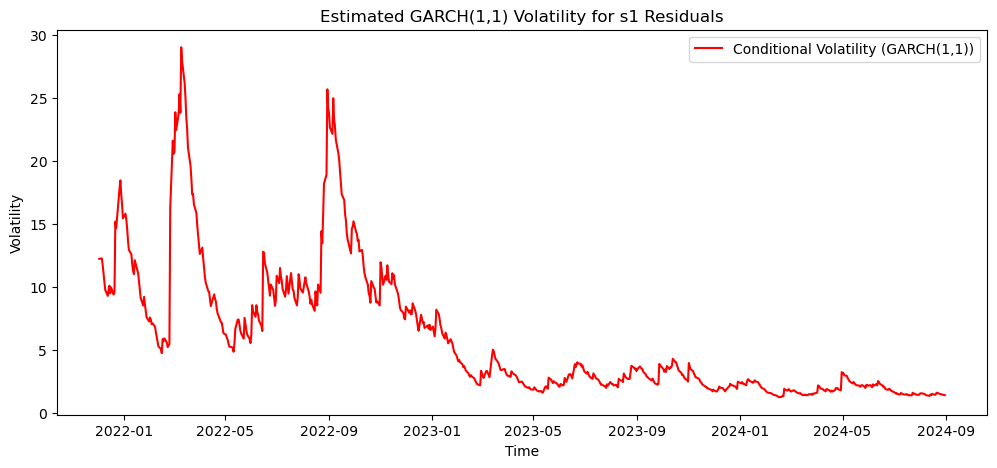

In [35]:
# Fits a GARCH(1,1) model to the residuals and plots the conditional volatility.
def fit_garch_model(spread_df, spread_column='s1', arima_results=None, p=1, q=1, mean='Zero', vol='GARCH', dist='t'):

    s1_series = spread_df[spread_column].dropna()
    resid_for_garch = arima_results.resid if arima_results else s1_series
    garch_model = arch_model(resid_for_garch, p=p, q=q, mean=mean, vol=vol, dist=dist)
    garch_res = garch_model.fit(update_freq=5)
    print(garch_res.summary())
    
    cond_vol = garch_res.conditional_volatility
    plt.figure(figsize=(12, 5))
    plt.plot(cond_vol, color='red', label=f'Conditional Volatility (GARCH({p},{q}))')
    plt.title(f"Estimated GARCH({p},{q}) Volatility for {spread_column} Residuals")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()
    return garch_res
garch_results = fit_garch_model(df_pair1, spread_column='s1', arima_results=arima_results, p=1, q=1)


- The GARCH(1,1) model captures volatility clustering in the spread s1, with significant parameters, indicating persistent volatility where shocks have long-lasting effects.
The sum ≈ 1.00 suggests a highly persistent volatility process, where large shocks lead to prolonged periods of elevated risk.
- The degrees of freedom ( 4.50 ) from the Student’s t-distribution confirm the presence of heavy tails, consistent with extreme events observed in the time series.
The conditional volatility plot shows sharp spikes during mid-2022, reflecting crisis-induced volatility surges, followed by a gradual tapering post-2023, indicating market stabilization. This emphasizes the need for volatility-aware strategies during periods of heightened

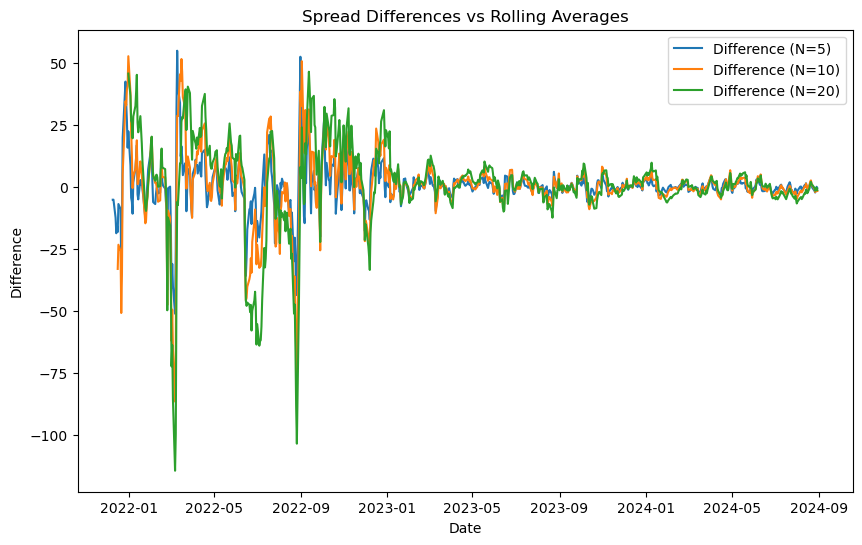

In [36]:
# Function to calculate the difference between the spread and N-day rolling average for multiple N values and plot
def calculate_and_plot_spread_difference(df, spread_col='s1', N_values=[5, 10, 20]):
    plt.figure(figsize=(10, 6))
    for N in N_values:
        df[f'diff_{N}'] = df[spread_col] - df[spread_col].rolling(window=N).mean()
        plt.plot(df.index, df[f'diff_{N}'], label=f'Difference (N={N})')
    
    plt.title('Spread Differences vs Rolling Averages')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.legend()
    plt.show()
calculate_and_plot_spread_difference(df_pair1, spread_col='s1', N_values=[5, 10, 20])

### Conclusion:
Beginning with data validation and descriptive analysis, we identified periods of extreme asymmetry, notably during the 2022 energy crisis. 
Visual tools like time-series plots and histograms, paired with statistical tests, confirmed the presence of heavy tails and non-normality. 
Through time series modeling, we captured mean-reversion with ARIMA and highlighted volatility clustering using GARCH, revealing the prolonged impact of market shocks. 
Structural break analysis and HMM-based regime detection unveiled distinct phases of calm and crisis, aligning with global economic disruptions. 
This approach underscored the need for adaptive, tail-aware models in risk management, illustrating how quantitative frameworks can provide robust insights into market dynamics and resilience amid uncertainty.

### Pair 2: 7. CBT.TU versus CBT.US × 0.7894

In [37]:
# Y instrument: CBT.TU
df_Y = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'TU')]
df_Y_second = select_second_month(df_Y)
df_Y_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,CBT,TU,TU,1M,109.242188,0.016468,-0.004078,-0.004768,0.000669,...,-0.850216,50.903726,29386.933092,5.827710e+05,-4.109265e+08,-2.431571e+10,-0.012035,0.006634,31.0,31.0
1,2021-12-06,CBT,TU,TU,1M,109.150000,0.016263,-0.005552,-0.004772,0.000832,...,-1.154042,60.283215,39043.700180,7.891772e+05,-4.662192e+08,-2.611277e+10,-0.012525,0.006625,31.0,31.0
2,2021-12-07,CBT,TU,TU,1M,109.040625,0.016424,-0.004993,-0.003925,0.001013,...,-0.922880,78.118617,23977.412496,-7.921378e+04,-2.089281e+08,-7.607722e+09,-0.011808,0.007551,31.0,31.0
3,2021-12-08,CBT,TU,TU,1M,109.065625,0.015349,-0.003759,-0.003169,0.001162,...,-0.831807,126.436080,35311.877661,-1.394790e+06,-5.537103e+08,-2.056880e+10,-0.009903,0.006238,31.0,31.0
4,2021-12-09,CBT,TU,TU,1M,109.039062,0.015355,-0.003979,-0.001998,0.000823,...,-0.903386,88.575862,36291.880019,-7.480978e+05,-4.461545e+08,-1.056958e+10,-0.008687,0.006601,31.0,31.0


In [38]:
# Z instrument: CBT.US
df_Z = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'US')]
df_Z_second = select_second_month(df_Z)
df_Z_second = df_Z_second.copy()
df_Z_second['futures_adj'] = df_Z_second['futures'] * 0.7894
df_Z_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,CBT,US,US,1M,162.709821,0.107847,0.007096,0.018796,0.003367,...,6.724124,13.286012,-281.719028,-2317.172013,25987.918900,-0.071269,0.098269,31.0,31.0,128.443133
1,2021-12-06,CBT,US,US,1M,161.140453,0.103458,0.001134,0.007704,0.002821,...,6.565345,48.714279,-480.779410,-6268.082671,64819.069390,-0.069529,0.085734,31.0,31.0,127.204274
2,2021-12-07,CBT,US,US,1M,160.203640,0.096955,0.000365,0.004507,0.002190,...,5.612642,39.577981,280.500722,-5139.060144,-19408.259457,-0.066813,0.083370,31.0,31.0,126.464754
3,2021-12-08,CBT,US,US,1M,159.132898,0.092402,-0.000578,0.002729,0.001940,...,5.469011,54.549282,434.971127,-8477.950753,-15427.808922,-0.065051,0.077948,31.0,31.0,125.619510
4,2021-12-09,CBT,US,US,1M,159.624657,0.093742,-0.002043,0.000406,0.002458,...,6.989844,64.648622,-334.945390,-8916.140117,69667.097312,-0.065556,0.081113,31.0,31.0,126.007704


In [39]:
df_pair2 = pd.merge(
    df_Y_second[['date', 'futures']],
    df_Z_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)
df_pair2.rename(columns={'futures': 'Y', 'futures_adj': 'Z'}, inplace=True)
df_pair2.head()

,date,Y,Z
0,2021-12-03,109.242188,128.443133
1,2021-12-06,109.150000,127.204274
2,2021-12-07,109.040625,126.464754
3,2021-12-08,109.065625,125.619510
4,2021-12-09,109.039062,126.007704


In [40]:
df_pair2['s2'] = df_pair2['Z'] - df_pair2['Y']
df_pair2.set_index('date', inplace=True)
df_pair2.sort_index(inplace=True)
df_pair2.head()

,Y,Z,s2
date,,,
2021-12-03,109.242188,128.443133,19.200946
2021-12-06,109.150000,127.204274,18.054274
2021-12-07,109.040625,126.464754,17.424129
2021-12-08,109.065625,125.619510,16.553885
2021-12-09,109.039062,126.007704,16.968641


In [41]:
analyze_spread_data(df_pair2, "s2")


--- s2 Information ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2021-12-03 to 2024-08-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       715 non-null    float64
 1   Z       715 non-null    float64
 2   s2      715 non-null    float64
dtypes: float64(3)
memory usage: 22.3 KB
None

--- Missing Values ---
Y     0
Z     0
s2    0
dtype: int64

--- Describe Values ---
                Y           Z          s2
count  715.000000  715.000000  715.000000
mean   103.363468  102.034054   -1.329414
std      2.094010    9.949200    7.983488
min    100.869583   85.148121  -15.825837
25%    101.949368   94.456644   -7.614160
50%    102.571875   99.833883   -2.363162
75%    104.524227  107.556364    2.855279
max    109.242188  128.443133   19.200946

--- Duplicated Dates ---
0 duplicate entries found in index


- The spread  shows a mean of  and a standard deviation of , indicating a relatively stable distribution with fewer extreme deviations.
- The range from  to  highlights occasional fluctuations, but the symmetry and lower variance compared to  suggest a more balanced and predictable market relationship.

In [42]:
outliers_s2 = detect_outliers_zscore(df_pair2, spread_column='s2', threshold=3)
outliers_s2

Number of outliers in s2 (Z-score>3): 0


,Y,Z,s2,s2_zscore
date,,,,


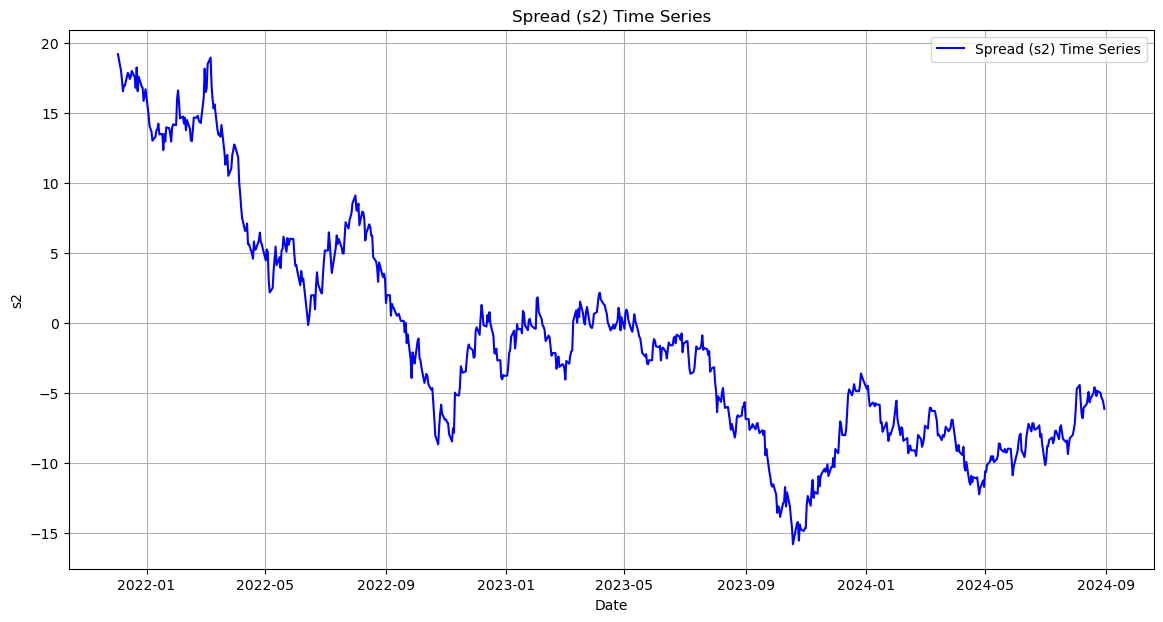

In [43]:
plot_spread_time_series(df_pair2, spread_column='s2', spread_name='Spread (s2) Time Series', color='blue')

- The time series plot of  reveals a gradual decline through 2022, reaching negative values around mid-2023, followed by a slow recovery.
- Unlike abrupt shocks seen in s1,  follows a smoother trend, indicating a more gradual market adjustment.
- This behavior suggests underlying macroeconomic influences driving a sustained shift rather than sudden volatility spikes.

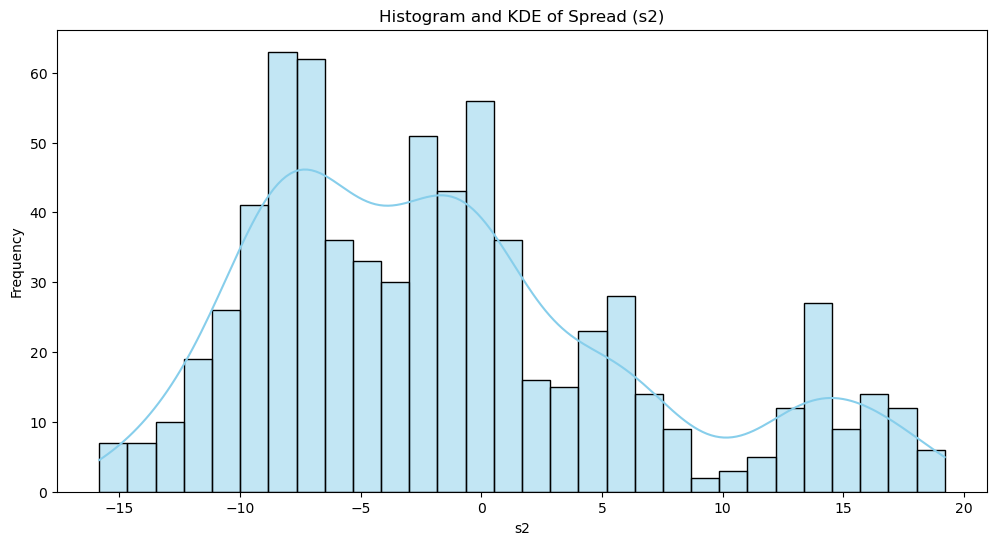

In [44]:
plot_spread_histogram_kde(df_pair2, spread_column='s2', spread_name='Spread (s2)', bins=30, color='skyblue')

- The histogram and KDE plot of s2 display a near-symmetrical distribution with a slight leftward shift, reinforcing a consistent negative bias.
- Unlike the extreme tails seen in s1, s2's values are more concentrated around the mean, indicating fewer extreme deviations.
- The peaks suggest periodic clustering of values, reflecting stable periods followed by short-term corrections without major market dislocations.

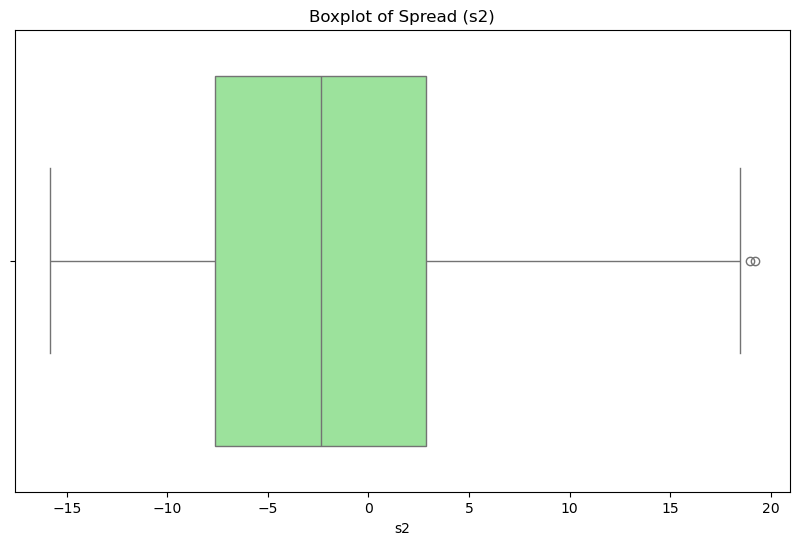

In [45]:
# Plots a boxplot of the given spread data.
plot_spread_boxplot(df_pair2, spread_column='s2', spread_name='Spread (s2)', color='lightgreen')

- The boxplot of s2 confirms a tight interquartile range, indicating limited variability compared to the extreme fluctuations of s2.
- The spread has few outliers, with most data points falling within a balanced range, emphasizing a more predictable market structure.



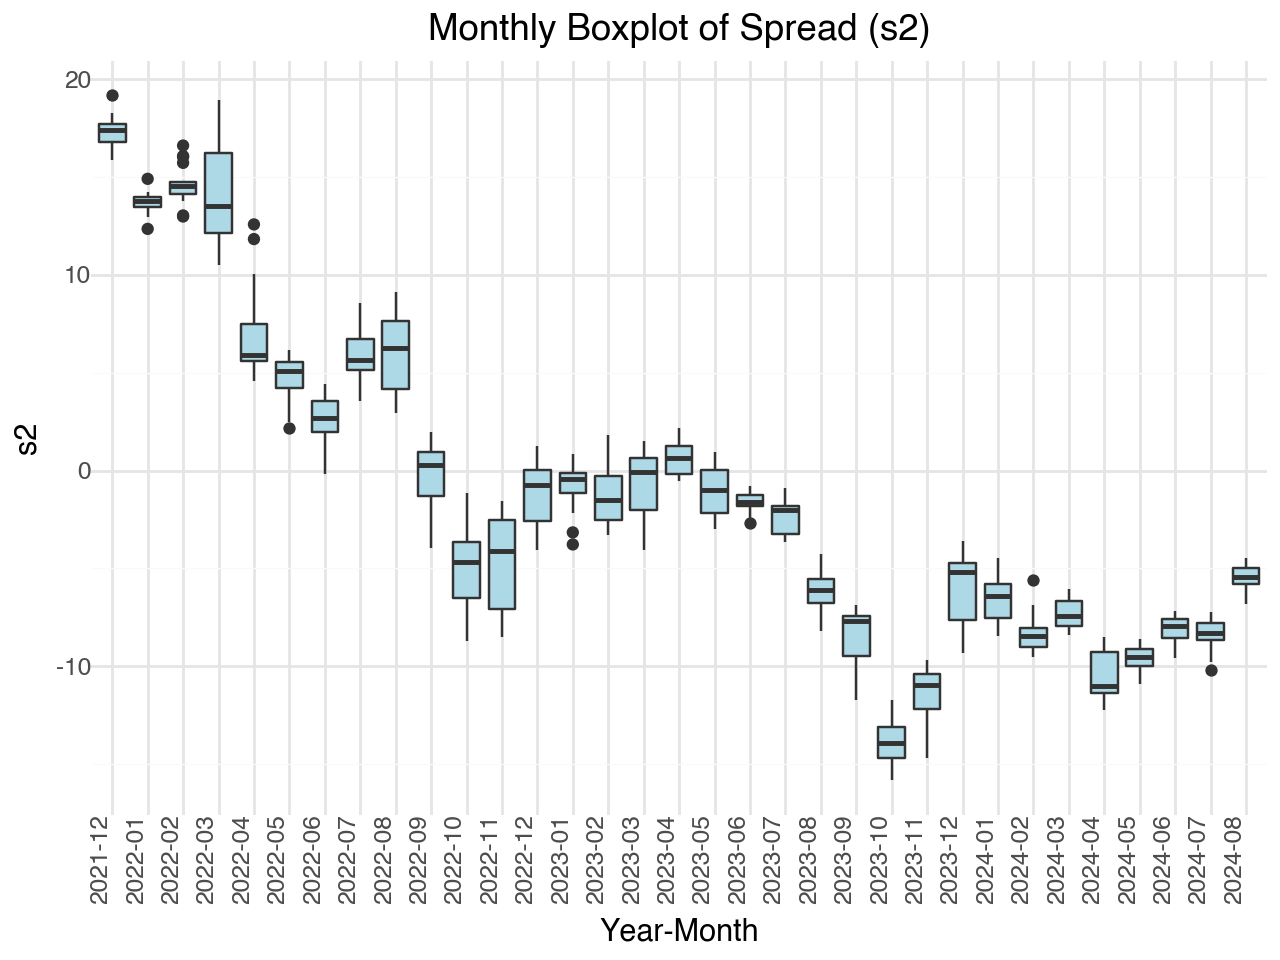

In [46]:
# Plots a monthly boxplot of the given spread data using plotnine.
p2_box = plot_monthly_boxplot(df_pair2, date_column='date', spread_column='s2', spread_name='Spread (s2)')
p2_box

- The monthly boxplot of s2 reveals a steady downward trend during 2022, with the median values consistently decreasing.
- The spread narrows by late 2023 and 2024, indicating reduced variability and stabilization after significant declines.
- Outliers in early 2022 highlight intermittent corrections before the downward trend fully took hold, reflecting changing market pressures.

In [47]:
# Computes and returns a DataFrame of quantiles, mean, median, standard deviation, skewness, and kurtosis of the spread.
spread_stats_df = compute_spread_statistics(df_pair2, spread_column='s2', spread_name='Spread (s2)')
spread_stats_df

,Quantiles,Statistic,Value
0,-14.564192,1% Quantile,NaN
1,-11.585995,5% Quantile,NaN
2,-7.614160,25% Quantile,NaN
3,-2.363162,Median (50%),NaN
4,2.855279,75% Quantile,NaN
5,14.765371,95% Quantile,NaN
6,17.849275,99% Quantile,NaN
7,NaN,Mean,-1.329414
8,NaN,Median,-2.363162
9,NaN,Standard Deviation,7.983488


- The quantile statistics of s2 confirm a relatively narrow range suggesting fewer extreme deviations.
- The mean of s2 and median of s2 highlight a slight left skew, but the low kurtosis indicates a flatter-than-normal distribution.
- The overall distribution reinforces that s2 experiences moderate fluctuations without heavy tails, indicative of a more stable yet occasionally volatile spread.

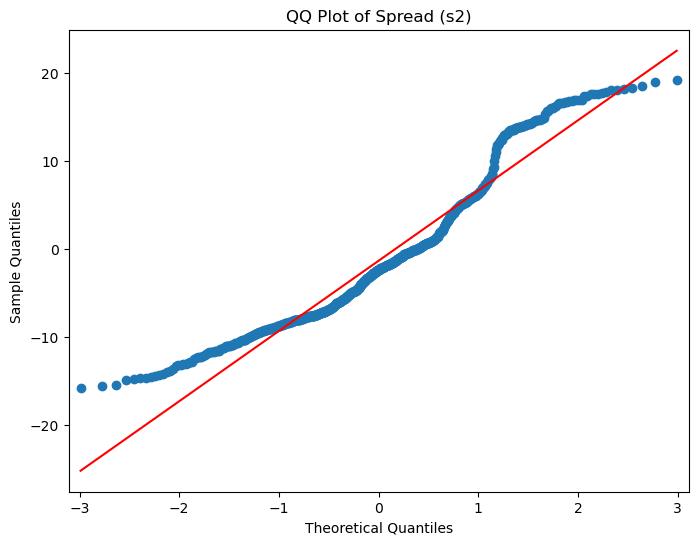

In [48]:
# Generates a QQ-plot for the given spread data.
plot_spread_qqplot(df_pair2, spread_column='s2', spread_name='Spread (s2)')

- The QQ plot of s2 shows deviations at the tails, with the left tail displaying slight concavity below the normal line, indicating mild negative skewness.
- The majority of the data points align well with the 45-degree line, supporting that the distribution approximates normality with only minor discrepancies at the extremes.



In [49]:
# Performs Kolmogorov-Smirnov test for normality on the given spread data.
ks_test_for_normality(df_pair2, spread_column='s2', spread_name='Spread (s2)', alpha=0.05)


Kolmogorov-Smirnov Test for Normality - Spread (s2):
KS Statistic: 0.0968
p-value: 0.0000
Reject the null hypothesis: The spread does not follow a normal distribution.


- The KS statistic of 0.0968 with a p-value of 0.0000 leads to rejecting the null hypothesis, confirming that the spread s2 does not follow a normal distribution despite its near-alignment in the QQ plot's center.
- This result highlights subtle but significant deviations in the tails, highlighting the need for models that account for such non-normal characteristics.



In [50]:
adf_s2 = ts.adfuller(df_pair2['s2'].dropna(), autolag='AIC')
print_adf_results(adf_s2, "s2")


ADF Test for s2:
  ADF Statistic: -2.510090958546446
  p-value:       0.11303835147424413
     Critical Value (1%): -3.4395418285955563
     Critical Value (5%): -2.865596454500293
     Critical Value (10%): -2.5689301318958955


- The ADF test statistic of -2.51 with a p-value of 0.113 fails to reject the null hypothesis of a unit root at the 5% significance level, suggesting that s2 may be non-stationary.
- The test indicates that while there may be some trend-stationary behavior, further transformations or tests may be required to ensure robustness.

In [51]:
# Fits Normal and Student's t-distribution to the data and computes log-likelihood, AIC, and BIC.
fit_summary = fit_distributions_and_compare(df_pair2, spread_column='s2')
print(fit_summary)


Distribution Fit Summary:
  Distribution  Log-Likelihood          AIC          BIC
0       Normal    -2499.364487  5002.728973  5011.873538
1  Student's t    -2499.364137  5004.728273  5018.445121


- The comparison of normal and Student's t distributions shows nearly identical log-likelihood values (~-2499.36).
- However, the AIC for the Student's t distribution is slightly higher (5004.73 vs. 5002.73), suggesting marginally less parsimony.
- The similarity in BIC also highlights minimal differentiation, indicating that both distributions fit similarly well, though the t-distribution may better capture slight tail variations.

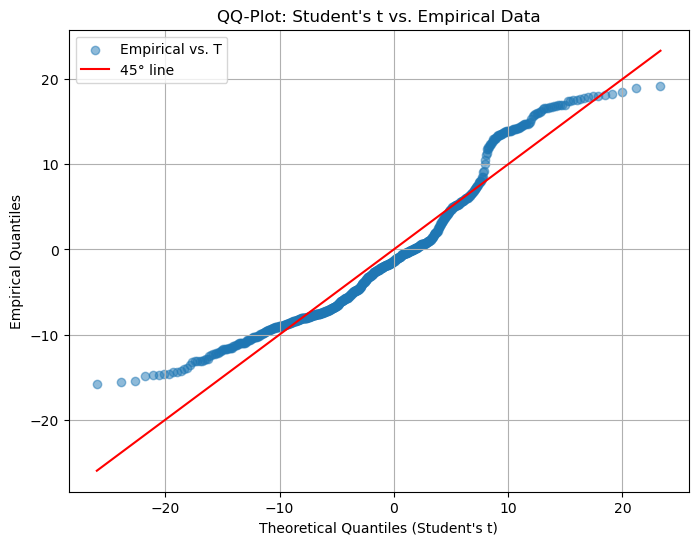

In [52]:
# Generates a QQ-plot comparing empirical data to theoretical quantiles of Student's t-distribution.
plot_t_distribution_qqplot(df_pair2, spread_column='s2')

- The QQ plot for Student's t distribution shows a strong fit at the center but some deviation at the tails, indicating that while the model captures the core distribution effectively, the extremities still display more pronounced fluctuations.
- This supports the intuition that occasional large deviations are not fully captured by traditional assumptions and require further model enhancements for tail risk.

Optimal KDE Bandwidth = 5.00


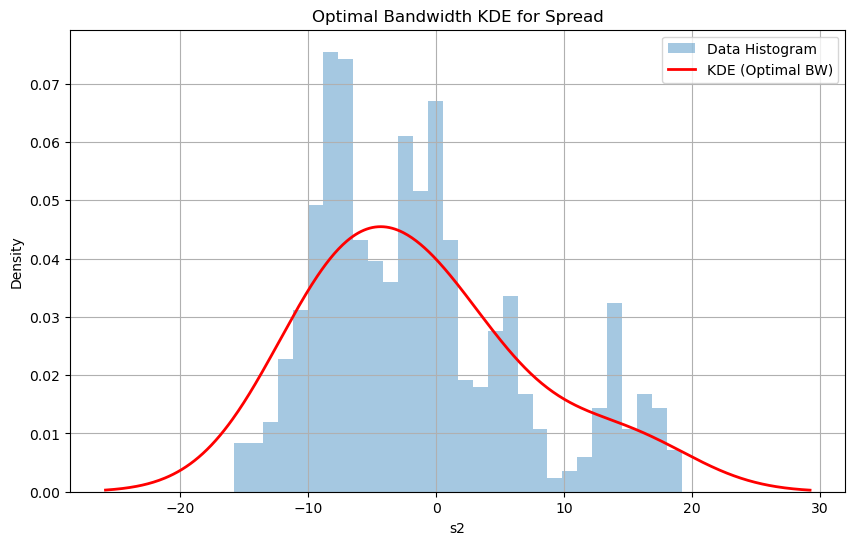

In [53]:
# Fits a KDE with optimal bandwidth and plots the density estimate along with the histogram.
plot_optimal_kde(df_pair2, spread_column='s2', bins=30)

- The KDE plot with optimal bandwidth further supports the balanced nature of the spread's distribution, showing smooth transitions in density without abrupt spikes.
- This plot confirms that the majority of observations are concentrated near the center, with moderate dispersion toward the tails.

In [54]:
# Performs bootstrap resampling and computes confidence intervals for the mean, skewness, and quantiles.
bootstrap_results = bootstrap_confidence_intervals(df_pair2, spread_column='s2', n_boot=1000, ci_percent=95)


--- Bootstrap Confidence Intervals ---
Mean 95% CI: (-1.9181319004962416, -0.7290225328541491)
Skewness 95% CI: (0.6477717848551958, 0.8682464617863298)
5% Quantile 95% CI: (-12.219486218750001, -10.954228903416496)
95% Quantile 95% CI: (14.097307898348193, 16.34120922426358)


- The 95% confidence interval for the mean (-1.90, -0.74) confirms a close clustering around a slightly negative average, indicating a moderate bias.
- The skewness confidence interval (0.65, 0.87) reflects mild positive skew, hinting at slight asymmetry.
- Additionally, the 5% and 95% quantile confidence intervals show that the tails remain bounded, with values (-12.23, -10.97) for the lower tail and (14.13, 16.36) for the upper tail, suggesting controlled extreme deviations.

In [55]:
# Fits a Generalized Pareto Distribution (GPD) to the negative tail of the spread data.
gpd_results = fit_gpd_negative_tail(df_pair2, spread_column='s2', percentile_threshold=5)

--- GPD Fit (Negative Tail) ---
Threshold (5th Percentile): -11.5860
Shape: -0.6446, Loc: 0.0433, Scale: 2.8183
GPD Log-Likelihood: -50.10
GPD AIC: 104.19


- The generalized Pareto distribution (GPD) fit to the negative tail of the spread data provides insights into extreme events. - With a threshold at the 5th percentile (-11.5860), the shape parameter of -0.6446 indicates a bounded tail, suggesting that extreme negative deviations are not heavy-tailed but rather limited in magnitude.
- The log-likelihood of -50.10 and AIC of 104.19 indicate the model's goodness of fit, reinforcing that the most extreme values are statistically predictable within finite bounds.

In [56]:
# Computes the Value at Risk (VaR) and Expected Shortfall (ES) based on the GPD fit.
var_95, es_95 = gpd_var_es(prob=0.95, threshold=gpd_results['threshold'], shape=gpd_results['shape'], scale=gpd_results['scale'])
print(f"95% VaR (negative tail) ~ {var_95:.2f}")
print(f"95% Expected Shortfall (negative tail) ~ {es_95:.2f}")

95% VaR (negative tail) ~ -15.32
95% Expected Shortfall (negative tail) ~ -9.21


- Additionally, the 95% Value at Risk (VaR) is estimated at approximately -15.32, indicating the potential loss at this confidence level, while the 95% Expected Shortfall (ES) of -9.21 quantifies the average loss beyond the VaR point, reflecting more severe but expected average losses in the worst-case scenarios.

In [57]:
# Computes and plots rolling mean and standard deviation for specified window sizes.
plot_rolling_statistics(df_pair2, spreabd_column='s2', window_sizes=[20, 60, 120])

TypeError: plot_rolling_statistics() got an unexpected keyword argument 'spreabd_column'

- The rolling means (20-day, 60-day, and 120-day) highlight the spread's gradual decline during 2022, suggesting a consistent downward trend. The convergence of the lines around 2023 and 2024 reflects a stabilization phase where short-term and long-term averages are aligned.
- The rolling standard deviation plot reveals periods of high volatility, particularly in mid-2022 and early 2023, followed by a marked decrease in variance. This indicates that while the spread initially experienced significant fluctuations, it entered a phase of relative calm by 2024.
- These observations provide key insights into the market's shifting dynamics, where initial instability was followed by a reversion to more predictable patterns, likely due to structural adjustments or external market influences.
- The stabilization in volatility underscores improved market resilience, with fewer extreme price deviations, suggesting that the market may have absorbed prior shocks and returned to a more balanced state.

In [ ]:
# Computes and plots rolling skewness and kurtosis for specified window sizes.
plot_rolling_moments(df_pair2, spread_column='s2', window_sizes=[20, 60, 120])

- The rolling skewness shows alternating patterns of positive and negative skewness, indicating fluctuations between right-tailed and left-tailed distributions. This reflects market phases where extreme positive or negative spread values became more probable.
- The rolling kurtosis plot indicates how "peaked" or "flattened" the distribution of the spread became over time. Notable peaks in kurtosis correspond to periods of extreme values, suggesting transient shocks or outlier events.
- Combined, the skewness and kurtosis patterns highlight how the distribution of s2 was shaped by market events, demonstrating phases of clustering around the mean versus periods of heavy tails.

In [ ]:
# Computes and plots the rolling fit of Student's t-distribution parameters.
rolling_t_fit_df = plot_rolling_student_t_fit(df_pair2, spread_column='s2', window=60)

- The rolling degrees of freedom for the Student's t-distribution applied to s2 reflect significant variability in the tail behavior of the spread. Periods, where degrees of freedom approach low values, indicate thicker tails and increased potential for extreme values.
- This variability suggests that the spread encounters episodes of heightened uncertainty or shock, where extreme deviations become more likely. Conversely, during more stable periods, the degrees of freedom increase, signifying more normalized behavior akin to a normal distribution.

In [ ]:
# Plots the ACF and PACF for the given spread data.
plot_acf_pacf(df_pair2, spread_column='s2', lags=40)

- The strong ACF decay and minimal PACF lags align with an autoregressive integrated moving average (ARIMA) structure, reinforcing the time series' persistent trends and cyclical nature. This highlights the importance of considering lagged values to model the spread s2 effectively.
- Additionally, this autocorrelation structure indicates that periods of increased clustering around specific values may represent phases of market adjustment rather than random shocks, supporting more precise risk management strategies.

In [ ]:
breakpoints = detect_structural_breaks(df_pair2, spread_column='s2', n_bkps=5, model_type='l2')

- Structural break analysis through binary segmentation identified key time points marking distinct economic phases or shocks.

In [ ]:
# Fits a Gaussian HMM to the spread returns and plots the inferred states.
model, states = plot_hmm_states(df_pair2, spread_column='s2', num_states=2, n_iter=100)

- HMM-derived states provided further confirmation of two distinct regimes, highlighting shifts between periods of stability and high variability.

In [ ]:
# Fits an ARIMA model to the spread time series and prints the summary.
arima_results = fit_arima_model(df_pair2, spread_column='s2', order=(1, 0, 1))

- The SARIMAX model results for the spread s2  provide a comprehensive view of the temporal dependencies and noise structure within the series. The selected model suggests an autoregressive component of order 1 and a moving average component of order 1, capturing both immediate and lagged effects.
- The Ljung-Box Q statistic indicates that the residuals exhibit no significant autocorrelation, confirming that the model adequately accounts for serial dependencies. The histogram and Q-Q plot of residuals show a close alignment with normality, although slight deviations in the tails suggest minor imperfections in capturing extreme values.
- The Jarque-Bera test result supports the null hypothesis of normality, indicating that the residuals do not significantly diverge from a Gaussian distribution. The low skewness and kurtosis values reflect a near-symmetric distribution with minimal heavy-tailed behavior.
- The correlogram shows minimal residual autocorrelations, reinforcing the model’s effectiveness in filtering out serial correlations. 

In [ ]:
# Fits a GARCH(1,1) model to the residuals and plots the conditional volatility.
garch_results = fit_garch_model(df_pair2, spread_column='s2', arima_results=arima_results, p=1, q=1)

- The volatility plot demonstrates that the variance was notably higher during early periods of the sample, likely influenced by external market shocks, but gradually stabilized over time.
- The volatility clustering behavior, as evidenced in the GARCH(1,1) plot, highlights periods of high uncertainty followed by more smooth phases.
- From a practical perspective, this analysis highlights the importance of accounting for conditional volatility when developing risk management strategies for spread-related positions.
- The decline in conditional volatility over time aligns with a more stable market regime. However, the occasional surges in variance imply that sudden systemic shocks are still possible, necessitating robust hedging mechanisms.

### Conclusion: 
The analysis of spread s2 indicates dynamic yet stabilizing behavior over time, with significant variation in early stages, followed by gradual stabilization. 
Key statistical tests, such as the Kolmogorov-Smirnov and ADF, highlighted the non-normality and weak stationarity of the spread. 
The distributional fit results suggested that the spread data aligns more closely with a Student's t-distribution than a normal distribution, pointing to heavy-tailed behavior. This is further supported by the skewness and kurtosis analysis, indicating a slight asymmetry and near-normal peakedness. 
Risk metrics, including Value at Risk (VaR) and Expected Shortfall (ES), showed moderate negative tail risk. Bootstrap confidence intervals reinforced these findings, while the GPD fit for negative tails underscored the importance of tail risk management.
The GARCH(1,1) model confirmed the presence of time-varying volatility, with early periods showing high conditional variance that tapered over time. This aligns with observed market events and highlights the need for adaptive hedging strategies in volatile regimes.

### Relative Dynamics

In [ ]:
# Function to calculate correlation between spreads from two DataFrames
def calculate_correlation(df1, df2, spread_col1='s1', spread_col2='s2'):
    correlation = df1[spread_col1].corr(df2[spread_col2]) 
    print(f"Correlation between the spreads ({spread_col1} and {spread_col2}): {correlation:.4f}")
    return correlation
    
calculate_correlation(df_pair1, df_pair2)

- The correlation between s1 and s2 is -0.4397, which indicates a moderate negative relationship between the two spreads.
- Such a correlation might suggest some degree of co-movement with opposite directionality, potentially reflecting hedging behavior or different market reactions to common external factors.